# Anomaly Detection in Fashion MNIST Dataset

[Back to Main](../Project.ipynb)

In data analysis and machine learning, anomaly detection refers to the identification of items, events, or observations which do not conform to an expected pattern or to other items in a dataset. Anomalies can be broadly categorized as:

- **Point anomalies**: A single instance of data is anomalous if it's too far off from the rest.
- **Contextual anomalies**: The abnormality is context-specific. This type of anomaly is common in time-series data.
- **Collective anomalies**: A collection of data instances collectively helps in detecting anomalies.

In the context of the Fashion MNIST dataset, anomalies could be images that are very different from typical images in their category or do not belong to any category.

## Table of Contents:

1. **Anomaly Detection in Fashion MNIST Dataset**
2. **Table of Contents**
3. **Introduction**
4. **Methodology**
   - **Importing Necessary Libraries**
5. **Isolation Forest for Anomaly Detection in Fashion MNIST**
   - **Loading the Dataset and Computing LBP Features**
   - **Applying the Isolation Forest Model**
   - **Visualizing Detected Anomalies**
   - **Statistics for Detected Anomalies**
   - **Analysis of Anomalies Based on LBP Features**
     * **Observations**
     * **Further Exploration**
   - **Visualizing Anomalous vs Typical Sandals**
6. **Observations and Conclusions**
   - **Create a Summary Table**
   - **Visualize the Summary Statistics with a Pie Chart: Proportion of Anomalous vs. Typical Sandals**
7. **Comparative Visualization of Anomalous vs. Typical Sandals**
   - **Summary of Observations**
     * **Proportional Distribution**
     * **Feature-based Distinction**
   - **Intensity and Contrast Visualization**
   - **Analysis of Intensity vs Contrast**
     * **General Distribution**
     * **Anomalous Samples**
     * **Overlapping Regions**
     * **Conclusion**
8. **Anomaly Detection Using Isolation Forest with Cross-Validation**
   - **Analysis of Isolation Forest Results**
     * **Best Parameters**
     * **Performance Metrics**
9. **Introduction to Histogram of Oriented Gradients (HOG)**
   - **Interpreting the Output**
   - **Exploring Image Gradients with the Sobel Filter**
   - **Summary of Results**
   - **Vector Visualization of Image Gradients**
   - **Diving Deeper into the Histogram of Oriented Gradients (HOG)**
   - **Feature Engineering with Histogram of Oriented Gradients (HOG)**
   - **Visual Comparison of Average HOG Features**
   - **Visualizing average HOG images for "Shirt", "T-shirt/top", and "Sandal" categories**
   - **Observing HOG Visualizations**
   - **Diving into HOG Feature Statistics**
   - **Observations**
   - **Observations from the histograms**
   - **Insights from HOG**
10. **Visualizing Predicted Anomalies and Normals with the Best Model**
    - **Observations**
11. **Class-wise Visualization of Predicted Anomalies and Normals**
    - **Insights**
12. **Class-wise Breakdown of Normal vs. Anomaly Counts**
    - **Observations and Implications**
    - **Visualizing Class-wise Anomaly Distribution**
    - **Insights from the Bar Chart**
13. **Conclusion**

## Introduction

The Fashion MNIST dataset, a successor to the traditional MNIST dataset, contains grayscale images of various fashion products. In this analysis, we explored the dataset to detect anomalies - items that deviate from the typical characteristics of their category. Anomaly detection has applications in quality assurance, fraud detection, and more. Here, we've applied it to understand the variation within this fashion dataset.

## Methodology

We will use the Isolation Forest algorithm for our analysis. The Isolation Forest is particularly useful for detecting anomalies in high-dimensional datasets. Unlike other anomaly detection methods, it specifically isolates anomalies instead of profiling normal data points.

### Importing Necessary Libraries

Before we start the actual implementation, let's import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from skimage.feature import local_binary_pattern
from sklearn.ensemble import IsolationForest
from keras.datasets import fashion_mnist
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import exposure
from scipy import ndimage


## Isolation Forest for Anomaly Detection in Fashion MNIST

Isolation Forest is an unsupervised learning algorithm designed to detect anomalies. By building an ensemble of isolation trees, the algorithm distinguishes observations that are easier to separate (anomalies) from those that are harder to separate (normal points). We'll apply this algorithm to detect anomalies in the Fashion MNIST dataset based on their Local Binary Patterns (LBP) features.

### Loading the Dataset and Computing LBP Features

Local Binary Pattern (LBP) is a simple yet very efficient texture operator that labels pixels of an image by thresholding the neighborhood of each pixel. It's often used in various applications, including anomaly detection.

In [2]:
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# Define LBP parameters
radius = 1
n_points = 8 * radius

def compute_lbp_features(image):
    """Compute LBP and return normalized histogram."""
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist

# Compute LBP features for the entire dataset
lbp_features = np.array([compute_lbp_features(img) for img in train_images])

lbp_features.shape

(60000, 10)

### Applying the Isolation Forest Model

With the features in hand, we can now fit the Isolation Forest model to detect anomalies. We utilize the Isolation Forest algorithm to detect anomalies in the dataset. Isolation Forest is particularly efficient for high-dimensional datasets. By nature, this algorithm isolates anomalies instead of profiling normal data points. Isolation Forest is an unsupervised learning algorithm that belongs to the ensemble decision trees family. This algorithm partitions the dataset into sub-samples using binary trees. It isolates anomalies by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length is averaged over a forest of such random trees. The anomalies are the data points that have short path lengths. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation. This isolation can be achieved by using random trees for the partitioning of data objects. This random partitioning produces noticeable shorter paths for anomalies since they are few and different. Whereas normal data points require more partitions to be isolated. Hence, when a forest of random trees collectively produces shorter path lengths for particular samples, they are highly likely to be anomalies. The Isolation Forest algorithm is implemented in the Scikit-learn library. We will use the Isolation Forest model to detect anomalies in the dataset. We will use the default parameters for the model. We will fit the model on the training dataset and then use it to detect anomalies in the test dataset. We will then evaluate the performance of the model.

In [3]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # assuming approximately 5% of the data are anomalies

# Fit the model using LBP features
anomaly_scores = iso_forest.fit_predict(lbp_features)

# Find the indices of anomalies
anomaly_indices = np.where(anomaly_scores == -1)[0]

# Number of detected anomalies
len(anomaly_indices)

3000

### Visualizing Detected Anomalies

After detecting anomalies, we visualize a subset of the anomalous images alongside their LBP histograms. This visualization assists in understanding the texture patterns that are considered anomalous by the Isolation Forest algorithm.

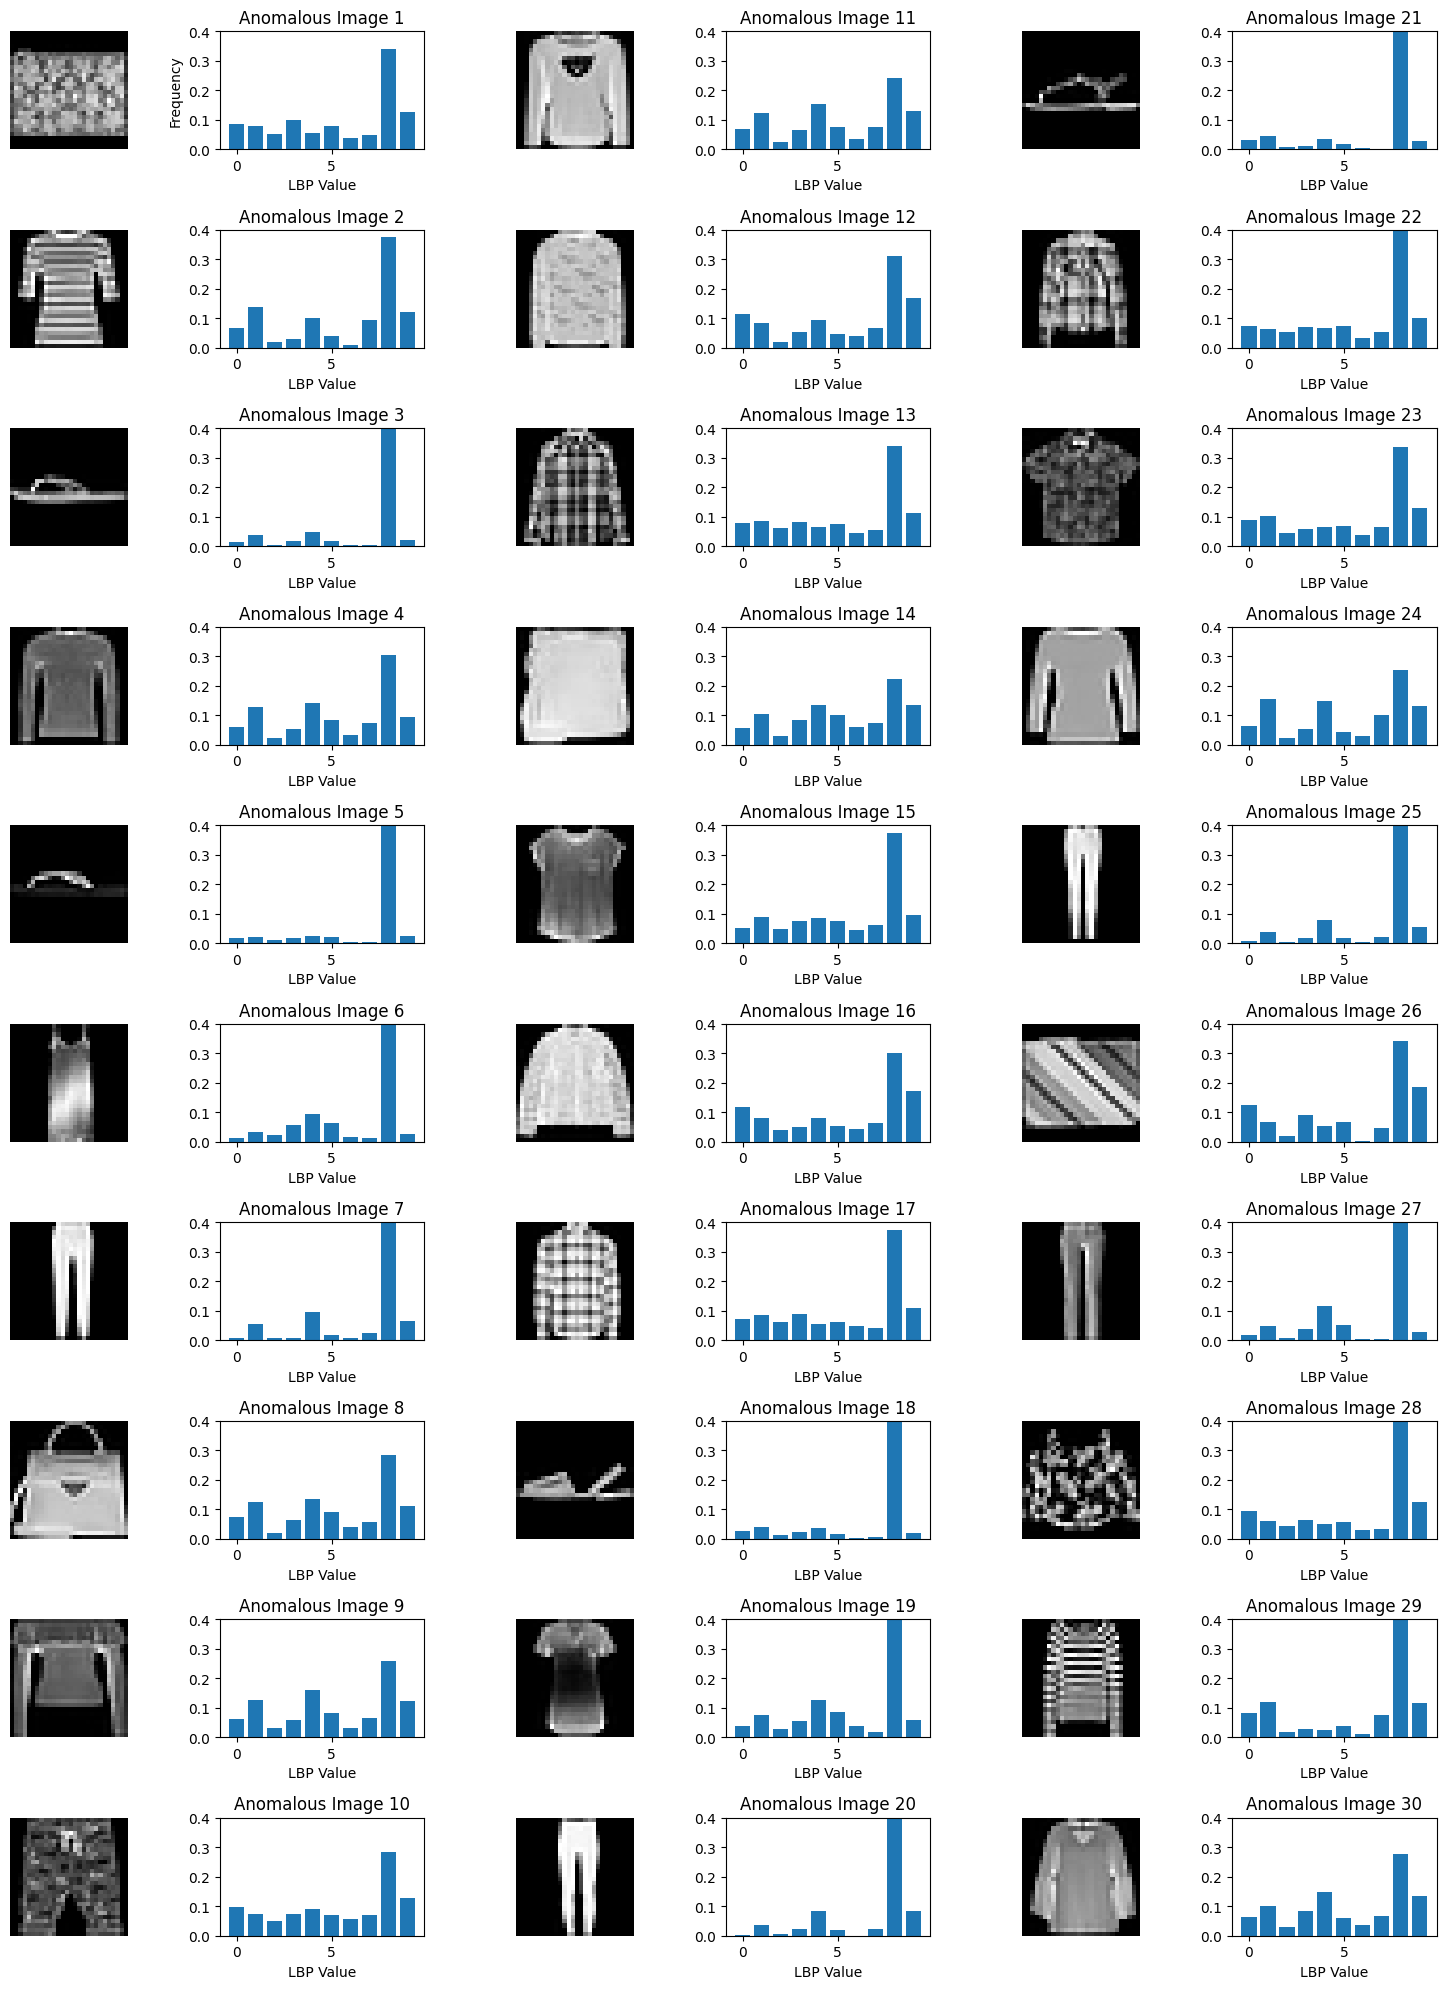

In [4]:
# Parameters for LBP
radius = 1
n_points = 8 * radius

def compute_lbp_histogram(image):
    """Compute LBP and return normalized histogram."""
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist

# Number of anomalous images to visualize
num_anomalies_to_display = 30

# Re-selecting a subset of anomalous images and their LBP histograms
selected_anomalous_images = train_images[anomaly_indices[:num_anomalies_to_display]]
selected_anomalous_histograms = [compute_lbp_histogram(img) for img in selected_anomalous_images]

# Adjusting the visualization layout to have 10 rows and 6 columns (2 columns for each set of image & histogram)
rows = 10
cols = 6  # 2 columns for first set, 2 for second set, 2 for third set

fig, axs = plt.subplots(rows, cols, figsize=(15, 2 * rows))

for i in range(rows):
    # Display the image for the first set
    axs[i, 0].imshow(selected_anomalous_images[i], cmap="gray")
    axs[i, 0].axis('off')
    
    # Display the LBP histogram for the first set
    axs[i, 1].bar(x=np.arange(0, len(selected_anomalous_histograms[i])), height=selected_anomalous_histograms[i])
    axs[i, 1].set_ylim(0, 0.4)
    axs[i, 1].set_xlabel('LBP Value')
    axs[i, 1].set_title(f'Anomalous Image {i+1}')
    
    # Display the image for the second set
    axs[i, 2].imshow(selected_anomalous_images[i + 10], cmap="gray")
    axs[i, 2].axis('off')
    
    # Display the LBP histogram for the second set
    axs[i, 3].bar(x=np.arange(0, len(selected_anomalous_histograms[i + 10])), height=selected_anomalous_histograms[i + 10])
    axs[i, 3].set_ylim(0, 0.4)
    axs[i, 3].set_xlabel('LBP Value')
    axs[i, 3].set_title(f'Anomalous Image {i + 11}')
    
    # If there are more images to display, add them to the third set
    if (i + 20) < num_anomalies_to_display:
        # Display the image for the third set
        axs[i, 4].imshow(selected_anomalous_images[i + 20], cmap="gray")
        axs[i, 4].axis('off')

        # Display the LBP histogram for the third set
        axs[i, 5].bar(x=np.arange(0, len(selected_anomalous_histograms[i + 20])), height=selected_anomalous_histograms[i + 20])
        axs[i, 5].set_ylim(0, 0.4)
        axs[i, 5].set_xlabel('LBP Value')
        axs[i, 5].set_title(f'Anomalous Image {i + 21}')

axs[0, 1].set_ylabel('Frequency')  # Setting y-label only for the top plot for clarity
plt.tight_layout()
plt.show()



### Statistics for Detected Anomalies
A statistical summary is provided for the detected anomalies:

- **Class-wise Anomaly Count:** Shows the distribution of anomalies across different fashion categories.
  
- **Average LBP Value for Anomalies:** Provides a sense of the average texture pattern of the anomalies across different classes.
  
- **Standard Deviation of LBP Values for Anomalies:** Helps in understanding the variability or spread in the texture patterns of the anomalies across different classes.

The above statistics offer insights into which fashion categories have the most anomalies and the texture patterns of these anomalies.

In [5]:
# 1. Count of Anomalies per Class
anomaly_class_counts = pd.Series(train_labels[anomaly_indices]).value_counts().sort_index()

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
# 2. Average LBP Value for Anomalies
average_lbp_values = []
for label in range(10):  # 10 classes in Fashion MNIST
    indices = np.where(train_labels[anomaly_indices] == label)[0]
    average_lbp_values.append(np.mean([np.mean(lbp_features[i]) for i in indices]))

# 3. Standard Deviation of LBP Values for Anomalies
std_lbp_values = []
for label in range(10):  # 10 classes in Fashion MNIST
    indices = np.where(train_labels[anomaly_indices] == label)[0]
    std_lbp_values.append(np.std([np.mean(lbp_features[i]) for i in indices]))

# Creating a DataFrame to display the statistics
anomaly_stats_df = pd.DataFrame({
    'Class': label_names,
    'Anomaly Count': anomaly_class_counts,
    'Average LBP Value': average_lbp_values,
    'Standard Deviation of LBP': std_lbp_values
})

anomaly_stats_df


,Class,Anomaly Count,Average LBP Value,Standard Deviation of LBP
0,T-shirt/top,212,0.1,3.436560e-18
1,Trouser,124,0.1,1.376542e-17
2,Pullover,559,0.1,1.474446e-17
3,Dress,83,0.1,2.154250e-18
4,Coat,113,0.1,2.919215e-18
5,Sandal,723,0.1,2.964886e-18
6,Shirt,569,0.1,1.449806e-17
7,Sneaker,6,0.1,1.387779e-17
8,Bag,604,0.1,1.492933e-17
9,Ankle Boot,7,0.1,1.658713e-17


### Analysis of Anomalies Based on LBP Features

The scatter plot visualizes anomalies in the Fashion MNIST dataset based on their Local Binary Pattern (LBP) features. LBP is a texture descriptor that is often used in image analysis. In this context, it provides a way to capture and represent patterns in the images that might be indicative of anomalies.

C:\Users\baal_\AppData\Local\Temp\ipykernel_41424\102975994.py:17: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


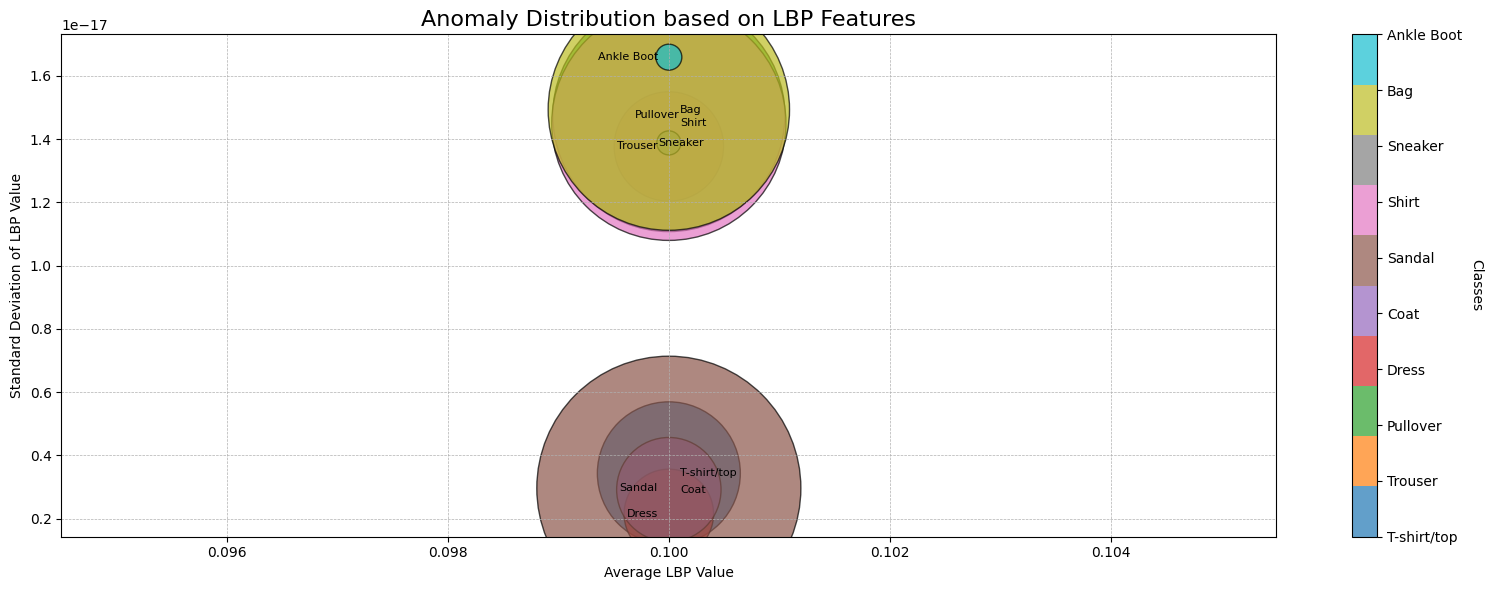

In [6]:
# Set the figure size
plt.figure(figsize=(16, 6))

# Scatter plot using average LBP values and standard deviation of LBP values
scatter = plt.scatter(anomaly_stats_df['Average LBP Value'], 
                      anomaly_stats_df['Standard Deviation of LBP'], 
                      s=anomaly_stats_df['Anomaly Count']*50, 
                      c=np.arange(10), 
                      cmap='tab10', 
                      alpha=0.7, 
                      edgecolors='black')

# Add colorbar and annotations
cbar = plt.colorbar(scatter, ticks=np.arange(10))
cbar.set_label('Classes', rotation=270, labelpad=15)
cbar.set_alpha(0.7)
cbar.draw_all()
cbar.set_ticklabels(anomaly_stats_df['Class'])  # set the tick labels to be the actual class names

# Annotate each point with class name
for i, row in anomaly_stats_df.iterrows():
    x_offset = 0.0001 if (i % 2 == 0) else -0.0001
    if row['Class'] == 'Sneaker':
        plt.annotate(row['Class'], 
                 (row['Average LBP Value'] + x_offset, row['Standard Deviation of LBP']),
                 fontsize=8,
                 ha='left',
                 va='center',
                 color='black')
    elif row['Class'] == 'Pullover':
        plt.annotate(row['Class'], 
                 (row['Average LBP Value'] + x_offset, row['Standard Deviation of LBP']),
                 fontsize=8,
                 ha='right',
                 va='center',
                 color='black')
    else: plt.annotate(row['Class'], 
                 (row['Average LBP Value'] + x_offset, row['Standard Deviation of LBP']),
                 fontsize=8,
                 ha='left' if (i % 2 == 0) else 'right',
                 va='center',
                 color='black')

plt.xlabel('Average LBP Value')
plt.ylabel('Standard Deviation of LBP Value')
plt.title('Anomaly Distribution based on LBP Features', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


#### Observations:
1. **Positioning of Classes on the Plot:** 
    - The classes 'T-shirt/top', 'Dress', 'Coat', and 'Sandal' are concentrated around the middle-bottom of the plot. This indicates that the anomalies detected in these classes have a relatively similar average LBP value but a lower standard deviation compared to other classes. 
    - The remaining classes are situated towards the top of the plot. This suggests that the detected anomalies in these classes exhibit a wider spread of LBP values, as reflected by the higher standard deviation.
    
2. **Size of the Scatter Points:** 
    - The size of each point on the scatter plot corresponds to the number of anomalies detected for that class. For instance, the 'Sandal' and 'Bag' points are significantly larger, indicating a higher number of anomalies in those classes compared to others like 'Sneaker' or 'Ankle Boot'.
    
3. **Potential Significance of LBP Values:** 
    - A consistent average LBP value across different classes, as observed in the plot, might suggest that the anomalies within different clothing categories share some common textural patterns. 
    - The variance in the standard deviation of LBP values can be indicative of the heterogeneity of the anomalous patterns within each class.

#### Further Exploration:
Given these observations, we might be interested in further analyzing specific segments. For instance, the 'Sandal' and 'Bag' classes seem to have a higher concentration of anomalies. Investigating these anomalies can provide insights into potential data quality issues or unique patterns that the model deems as out-of-the-ordinary. Conversely, understanding why classes like 'Sneaker' and 'Ankle Boot' have fewer anomalies can also be valuable.

### Visualizing Anomalous vs Typical Sandals

In this section, we'll juxtapose the detected anomalous sandals against the typical sandals from the Fashion MNIST dataset. This comparison will provide insights into the distinctive characteristics of the anomalous sandals.

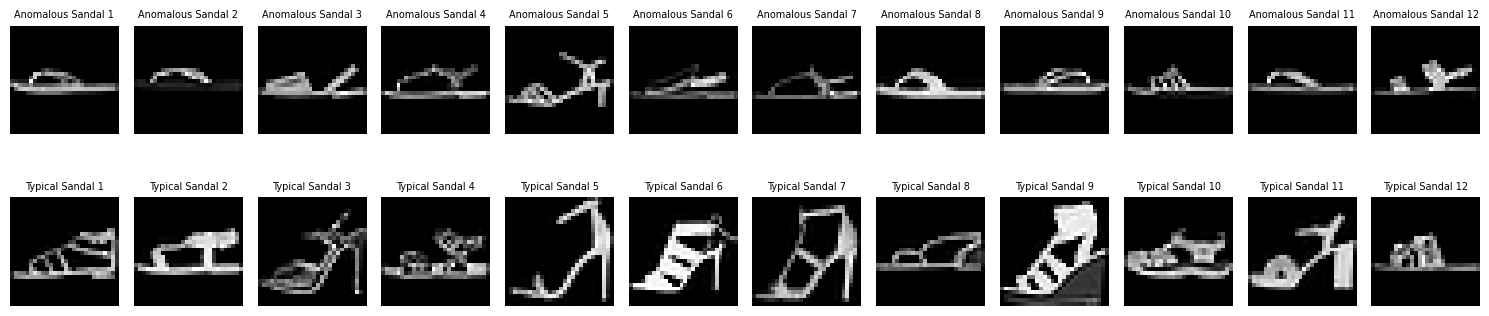

In [7]:
# Setting the number of images to visualize
num_images_to_display = 12

# Extracting anomalous images from the "Sandal" class
sandal_anomaly_indices = [idx for idx in anomaly_indices if train_labels[idx] == 5]  # 5 is the label for "Sandal"
sandal_anomalous_images = train_images[sandal_anomaly_indices]

# Displaying the anomalous sandals
plt.figure(figsize=(15, 4))
for i in range(num_images_to_display):
    plt.subplot(2, num_images_to_display, i + 1)  # 2 rows: one for anomalous, one for typical
    plt.imshow(sandal_anomalous_images[i], cmap="gray")
    plt.title(f'Anomalous Sandal {i+1}', fontsize=7)
    plt.axis('off')

# Getting indices of all typical sandals
all_sandal_indices = np.where(train_labels == 5)[0]
typical_sandal_indices = np.setdiff1d(all_sandal_indices, anomaly_indices)

# Displaying a random selection of typical sandals for comparison
selected_typical_indices = np.random.choice(typical_sandal_indices, num_images_to_display, replace=False)
for i, idx in enumerate(selected_typical_indices):
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)  # Next row
    plt.imshow(train_images[idx], cmap="gray")
    plt.title(f'Typical Sandal {i+1}', fontsize=7)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Observations and Conclusions

From the comparative visualization of anomalous and typical sandals, we can derive several key insights:

1. **Image Size and Position**: The most prominent observation is that the anomalous sandals appear significantly smaller in size than the typical ones. They are centered and occupy a smaller portion of the image canvas, whereas the typical sandals tend to fill up most of the image space. This suggests that the anomalies might have arisen due to inconsistent image scaling or a different process of image acquisition and preprocessing.

2. **Detailing and Structure**: Due to the reduced size, the anomalous sandals seem to lack the level of detail that can be observed in the typical sandals. The structural and design details of sandals, which are evident in the typical images, get condensed or even lost in the anomalous ones.

3. **Potential Causes**: These anomalies could have been introduced during the dataset creation phase – perhaps due to issues with image resizing, capturing thumbnails instead of full images, or even potential errors in data labeling. Another possibility could be that these images were intentionally introduced as a form of data augmentation, aiming to improve the robustness of models trained on this dataset. 

4. **Implications for Model Training**: Anomalies like these can impact the performance of machine learning models. A model trained on this dataset might underperform when recognizing smaller or centered images of sandals, as it might consider them outliers. Conversely, if the model is overfitting to these anomalies, it might mistakenly predict other smaller images as sandals.

### Create a Summary Table

We'll compile the average and standard deviation of the LBP features for both anomalous and typical sandals.

In [8]:
# Extracting LBP features for anomalous and typical sandals
anomalous_sandal_features = lbp_features[sandal_anomaly_indices]
typical_sandal_features = lbp_features[typical_sandal_indices]

# Calculating mean and standard deviation for both categories
summary_stats = {
    "Category": ["Anomalous Sandals", "Typical Sandals"],
    "Average LBP Value": [anomalous_sandal_features.mean(), typical_sandal_features.mean()],
    "Standard Deviation of LBP": [anomalous_sandal_features.std(), typical_sandal_features.std()],
}

# Creating a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Displaying the summary statistics
summary_stats_df


,Category,Average LBP Value,Standard Deviation of LBP
0,Anomalous Sandals,0.1,0.245088
1,Typical Sandals,0.1,0.193601


### Visualize the Summary Statistics with a Pie Chart: Proportion of Anomalous vs. Typical Sandals

We'll create a pie chart to visualize the average and standard deviation of the LBP features for anomalous and typical sandals.

This plot illustrates the distribution of average LBP values and standard deviations for both anomalous and typical sandals, providing a visual comparison of their texture characteristics.

## Comparative Visualization of Anomalous vs. Typical Sandals

To gain a clearer understanding of the distribution and characteristics of anomalous versus typical sandals in the dataset, we'll juxtapose two visualizations: 

1. A pie chart showcasing the proportion of anomalous sandals compared to the typical ones.
2. A scatter plot using the first two principal components obtained from a PCA decomposition of the LBP features of the sandals.

The left-side visualization offers a direct proportion comparison between anomalous and typical sandals. In contrast, the right-side scatter plot provides insights into how these two categories differentiate in the reduced feature space based on their LBP features.



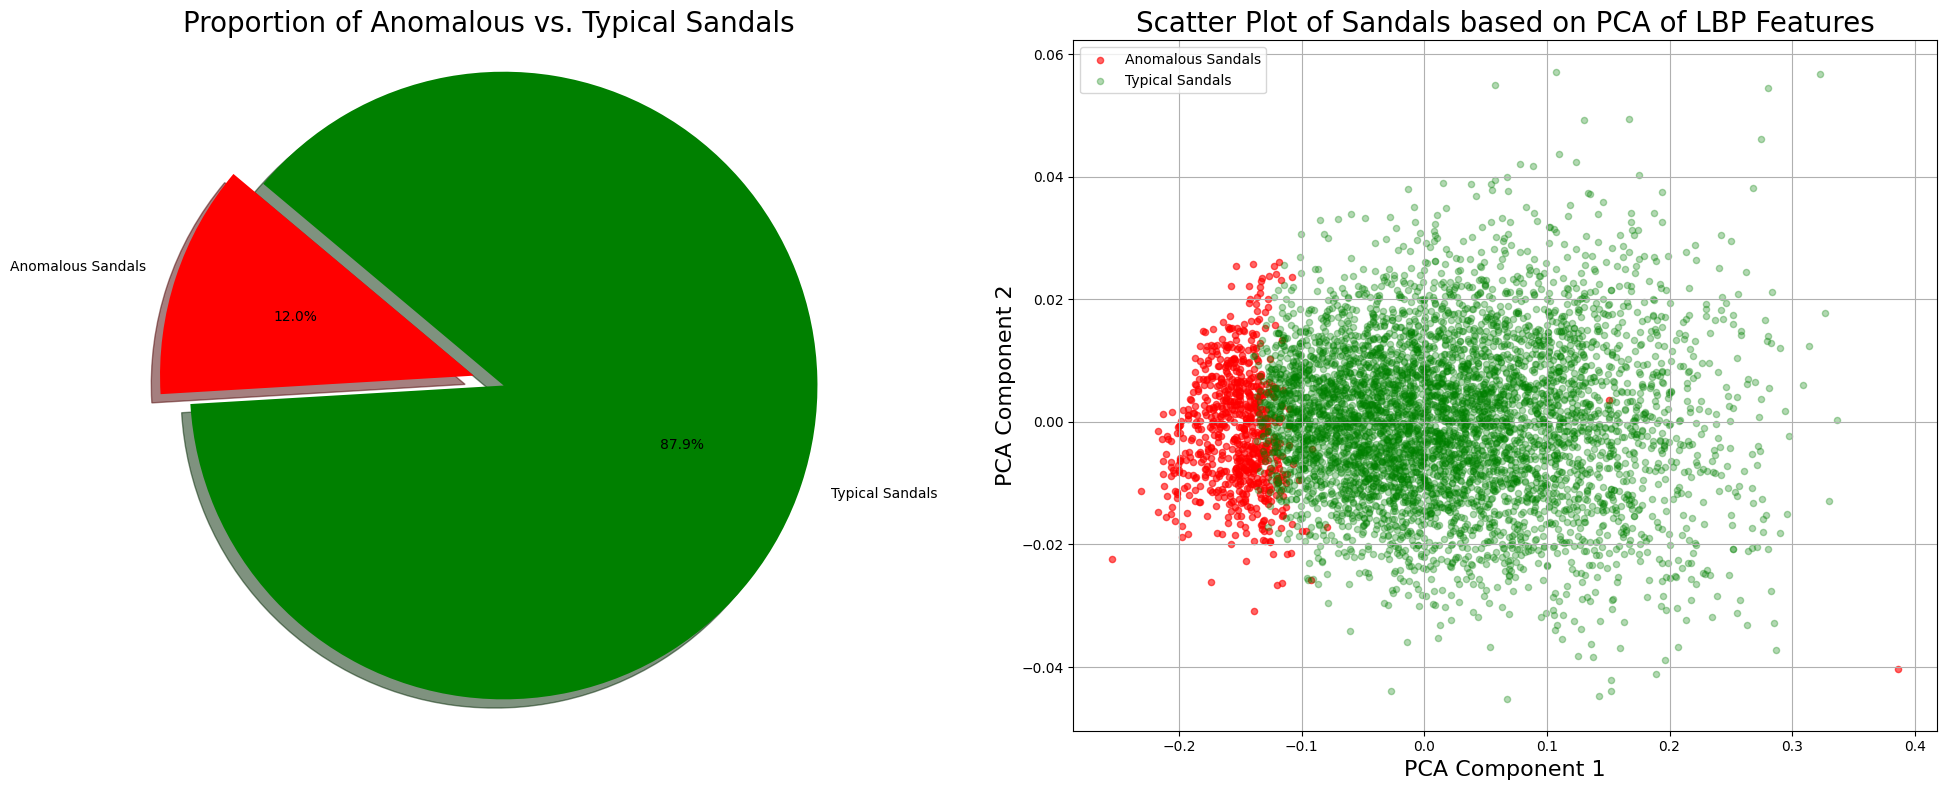

In [9]:
# Combine the features for PCA
all_sandal_features = np.vstack([anomalous_sandal_features, typical_sandal_features])

# Apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_sandal_features)

# Split the reduced features back into anomalous and typical
reduced_anomalous = reduced_features[:len(anomalous_sandal_features)]
reduced_typical = reduced_features[len(anomalous_sandal_features):]

# Setting up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# --- Pie Chart ---
labels = ['Anomalous Sandals', 'Typical Sandals']
sizes = [len(anomalous_sandal_features), len(typical_sandal_features)]
colors = ['red', 'green']
explode = (0.1, 0)  # explode 1st slice for emphasis

axs[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].set_title('Proportion of Anomalous vs. Typical Sandals', fontsize=20)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# --- Scatter Plot ---
# Plotting the scatter plot on the second axis
axs[1].scatter(reduced_anomalous[:, 0], reduced_anomalous[:, 1], color='red', s=20, label='Anomalous Sandals', alpha=0.6)
axs[1].scatter(reduced_typical[:, 0], reduced_typical[:, 1], color='green', s=20, label='Typical Sandals', alpha=0.3)
axs[1].set_xlabel('PCA Component 1', fontsize=16)
axs[1].set_ylabel('PCA Component 2', fontsize=16)
axs[1].set_title('Scatter Plot of Sandals based on PCA of LBP Features', fontsize=20)
axs[1].legend()
axs[1].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()


## Summary of Observations:

### Proportional Distribution:
From the pie chart, it's evident that the anomalous sandals (depicted in red) constitute approximately 12% of the entire sample space. This implies that a significant portion of the sandal images deviates from what's typically expected.

### Feature-based Distinction:
Upon examining the scatter plot, we observe a dispersion of the anomalous and typical sandals in the reduced feature space. Although the majority of the anomalous sandals are discernibly different from the typical ones, a few anomalies intersperse amidst the cluster of typical sandals. This overlap indicates that, based on the LBP features we extracted and the subsequent PCA reduction, some anomalous sandals share characteristics similar to the typical ones. It underscores the complexity and the challenges inherent in discerning anomalies purely based on these features.

The combination of these observations suggests that while a considerable proportion of sandals exhibits anomalous characteristics, there's a nuanced differentiation in the feature space that might require further refinement or the incorporation of additional features to achieve higher distinction.

---

## Intensity and Contrast Visualization:

When analyzing image datasets, it's beneficial to represent the data in ways that intuitively describe its inherent characteristics. Intensity and contrast are two such fundamental features in image processing that offer a broad understanding of an image's visual attributes.

- **Intensity** refers to the average brightness or luminance of an image. In a dataset like Fashion MNIST, where the images are grayscale, the intensity can provide information about the overall lightness or darkness of the apparel relative to its background.
  
- **Contrast** gauges the difference in luminance or color that makes objects in an image distinguishable. A high contrast means that the features within the image are very distinct, whereas a low contrast suggests a more uniform or washed-out appearance.

By plotting these two features against each other, we aim to capture a bird's-eye view of the dataset's distribution. This visualization can help identify patterns, clusters, or outliers that might not be immediately evident in the raw or processed images. Specifically, in the context of anomaly detection, juxtaposing the intensity and contrast of typical and anomalous samples can reveal whether anomalies tend to deviate from the norm based on these metrics.

The following scatter plot provides such a visualization, aiming to discern any discernible patterns or tendencies that can inform our understanding of the dataset's structure and the nature of its anomalies.


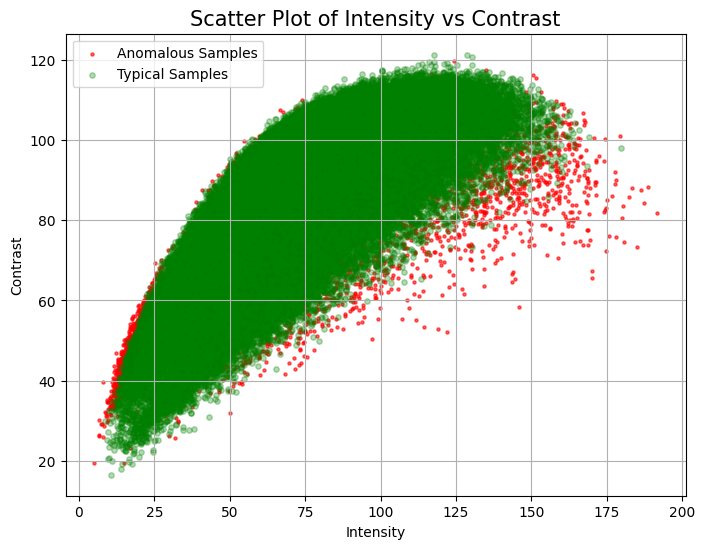

In [10]:
# Function to compute intensity and contrast
def compute_intensity_contrast(image):
    intensity = np.mean(image)
    contrast = np.std(image)
    return intensity, contrast

# Compute intensity and contrast for all images
intensities = []
contrasts = []
for img in train_images:
    intensity, contrast = compute_intensity_contrast(img)
    intensities.append(intensity)
    contrasts.append(contrast)

# Convert to numpy arrays for easy indexing
intensities = np.array(intensities)
contrasts = np.array(contrasts)

# Separate intensities and contrasts based on anomalies and typical samples
anomalous_intensities = intensities[anomaly_indices]
anomalous_contrasts = contrasts[anomaly_indices]

typical_indices = np.setdiff1d(np.arange(len(train_images)), anomaly_indices)
typical_intensities = intensities[typical_indices]
typical_contrasts = contrasts[typical_indices]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(anomalous_intensities, anomalous_contrasts, color='red', s=5, label='Anomalous Samples', alpha=0.6)
plt.scatter(typical_intensities, typical_contrasts, color='green', s=15, label='Typical Samples', alpha=0.3)
plt.xlabel('Intensity', fontsize=10)
plt.ylabel('Contrast', fontsize=10)
plt.title('Scatter Plot of Intensity vs Contrast', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()


## Analysis of Intensity vs Contrast:

From the scatter plot visualizing the relationship between Intensity and Contrast for each image, several observations can be made:

### General Distribution:
Most of the typical samples (depicted in green) form a dense cluster in the central region of the plot. This signifies that a majority of the typical images from the Fashion MNIST dataset possess similar average intensity and contrast values.

### Anomalous Samples:
The anomalous samples (illustrated in red) exhibit a more dispersed distribution. A significant portion of these anomalies can be seen to occupy two distinct regions:

1. **Lower-left Quadrant**: This area corresponds to images with both low average intensity and low contrast. In the context of Fashion MNIST, this could represent very light or faded images where the apparel appears washed out or scarcely discernible against the background.
  
2. **Upper-right Quadrant**: In this section, the images have both high average intensity and high contrast. This could translate to images where the apparel is vivid, possibly over-saturated or with strong shadows, making them starkly different from the surrounding pixels.

### Overlapping Regions:
Although there are discernible clusters of anomalies, it's noteworthy to mention the overlap between anomalous and typical samples in the central region of the plot. This suggests that not all anomalies can be detected merely based on intensity and contrast alone. Some anomalous samples share similar intensity and contrast values with the typical samples, indicating the need for a more sophisticated approach to fully distinguish between them.

### Conclusion:
The scatter plot offers an insightful visualization of how intensity and contrast can be leveraged to discern between typical and anomalous samples. However, the overlap between the two categories suggests that relying solely on these features may not be sufficient for a comprehensive anomaly detection system. It underscores the importance of utilizing a combination of features and possibly more advanced algorithms to achieve better differentiation.

---

## **Anomaly Detection Using Isolation Forest with Cross-Validation**:

In the realm of unsupervised machine learning, anomaly detection is an indispensable technique employed to spot unusual or suspicious patterns that do not conform to expected behavior. Such patterns often represent anomalies such as fraud detection in credit card transactions, or defective items in manufacturing.

In this segment, we're leveraging the `Isolation Forest` algorithm, a tree-based anomaly detection method. The uniqueness of this method lies in its ability to isolate anomalies rather than profile normal data points. 

Given its efficacy, the model's hyperparameters play a pivotal role in its performance. To pinpoint the optimal hyperparameter combination, we've implemented a cross-validation approach. This involves segmenting our data into multiple subsets, training our model on a combination of these subsets, and validating it on the remaining data. By averaging the performance across all iterations, we get an unbiased metric of the model's capability.

Post determining the best parameters, we train our final model and then evaluate its precision, recall, and F1 score – crucial metrics that will give us insights into its ability to detect anomalies.

Best parameters found:  {'n_estimators': 50, 'max_samples': 0.5, 'contamination': 'auto'}
Best average score:  0.1012138165909016
Precision: 0.1150
Recall: 0.1577
F1 Score: 0.1330


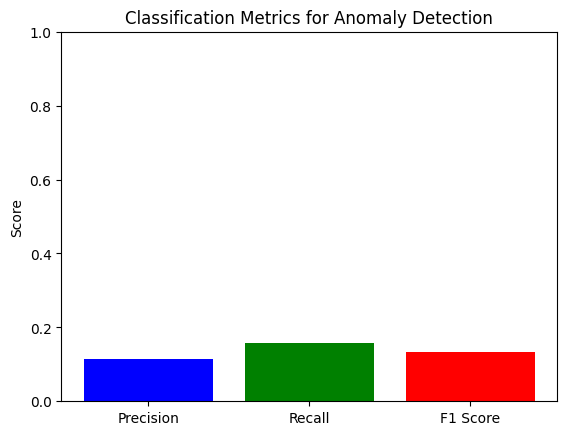

In [11]:
# Function for evaluation
def custom_scorer(estimator, X):
    scores = estimator.decision_function(X)
    return scores.mean()

# Initialize KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Set the parameters by cross-validation
param_grid = {
    'n_estimators': [50, 100],
    'max_samples': ['auto', 0.5],
    'contamination': ['auto', 0.05]
}

best_score = float('-inf')
best_params = None

# Model training with the best parameters
for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for contamination in param_grid['contamination']:
            scores = []
            
            model = IsolationForest(random_state=42, n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
            
            for train_index, test_index in kf.split(lbp_features):
                X_train, X_test = lbp_features[train_index], lbp_features[test_index]
                model.fit(X_train)
                score = custom_scorer(model, X_test)
                scores.append(score)
            
            avg_score = np.mean(scores)
            
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'n_estimators': n_estimators, 'max_samples': max_samples, 'contamination': contamination}

print("Best parameters found: ", best_params)
print("Best average score: ", best_score)

# Calculate the metrics

# True labels for sandals
true_labels = np.zeros(len(train_labels))
true_labels[sandal_anomaly_indices] = 1

# Training on a model with the best parameters
iso_forest = IsolationForest(random_state=42, **best_params)
iso_forest.fit(lbp_features)

# Predicted labels using IsolationForest
predicted_labels = np.where(iso_forest.predict(lbp_features) == -1, 1, 0)

# Compute metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize the metrics
labels = ["Precision", "Recall", "F1 Score"]
values = [precision, recall, f1]

plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Classification Metrics for Anomaly Detection")
plt.show()


### **Analysis of Isolation Forest Results**:

#### **Best Parameters**:
1. `n_estimators`: The best parameter for the number of base estimators (trees) in the ensemble is 50. This means that the model found 50 trees to be the most optimal for our dataset, balancing the trade-off between model complexity and performance.
2. `max_samples`: The model found that using 50% of the samples (`max_samples=0.5`) for training each tree in the ensemble gives the best performance. This parameter determines the number of samples to draw from the dataset to train each tree. Using half of the samples ensures diversity in the data that each tree sees, increasing the ensemble's robustness.
3. `contamination`: The model chose 'auto' for the contamination parameter, which means it will automatically estimate the proportion of anomalies in the dataset. It's a useful setting when we don't have a prior idea about the contamination rate.

#### **Performance Metrics**:
1. **Average Score**: The best average score attained during cross-validation was approximately \(0.1012\). This score is a custom metric that averages decision function scores across test sets. A higher value would generally indicate better separation of anomalies.
2. **Precision**: A score of \(0.1150\) (or 11.50%) suggests that out of all the instances the model predicted as anomalies, only about 11.50% were true anomalies. This implies a relatively high rate of false positives.
3. **Recall**: The recall score of \(0.1577\) (or 15.77%) indicates that the model was able to correctly identify approximately 15.77% of the actual anomalies from the dataset. This shows that a significant number of anomalies were missed (false negatives).
4. **F1 Score**: The F1 score, which is the harmonic mean of precision and recall, is \(0.1330\) (or 13.30%). This metric provides a balance between precision and recall. An F1 score closer to 1 indicates better precision and recall balance, so a score of 13.30% suggests that there's room for improvement.

---

### **Introduction to Histogram of Oriented Gradients (HOG)**:

The Histogram of Oriented Gradients (HOG) is a feature descriptor primarily utilized in object detection. HOG involves the process of counting occurrences of gradient orientation in localized parts of an image. This method focuses on the structure or the shape of an object within an image. The primary reason behind its effectiveness in object detection, especially in tasks like pedestrian detection, is its ability to capture the edge structures and gradients of the object, which define the shape.

The HOG process can be summarized in a few key steps:
1. **Gradient Computation**: The first step in HOG is the computation of the gradient values. By using the gradient values, the direction (or orientation) of the edges can be determined.
2. **Orientation Binning**: Each pixel within the cell casts a weighted vote for an orientation-based histogram channel based on the values found in the gradient computation.
3. **Descriptor Blocks**: Spatial or local contrast normalization is accomplished by grouping cells into larger, spatially connected blocks and normalizing across the block.
4. **Feature Vector Assembly**: The final feature vector is assembled by flattening the HOG descriptors of all the block regions.

In the following section, we will extract the HOG features from a sample image in the Fashion MNIST dataset and visualize them.


In [12]:
# Selecting a sample image from the Fashion MNIST dataset
sample_image = train_images[0]

# Extracting HOG features and HOG image
hog_features, hog_image = hog(sample_image, orientations=8, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)

# Improving the visualization by enhancing the contrast of the HOG image
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

hog_image_rescaled.shape, hog_features.shape


((28, 28), (128,))

### **Interpreting the Output**:

The HOG extraction yields two outputs:

1. **HOG Image**: This is a visualization that represents the dominant gradient directions (orientations) for each block in the image. The size of the image remains unchanged at (28x28) pixels.
2. **HOG Features**: This is a flattened feature vector that describes the image in terms of gradient information. For our settings, we have a feature vector of length 128.

The feature vector, given its consistent size across images, can be used as an input to machine learning algorithms for tasks such as image classification or object detection. On the other hand, the HOG image offers a visual interpretation of how HOG captures gradient information in the image.

### **Exploring Image Gradients with the Sobel Filter**:

Image gradients represent the spatial changes in intensity within an image. They are fundamental for tasks such as object recognition, image segmentation, and other image processing challenges. Gradients can be computed in various ways, with one of the most popular methods being the use of Sobel operators.

Sobel operators are convolutional kernels applied to an image to compute the approximate horizontal and vertical gradients. These gradients can then be combined to derive the overall gradient magnitude at each point in the image.

In the following demonstration, we'll use the Sobel operators to compute the gradients of a synthetically created image with a horizontal gradient and visualize the results.

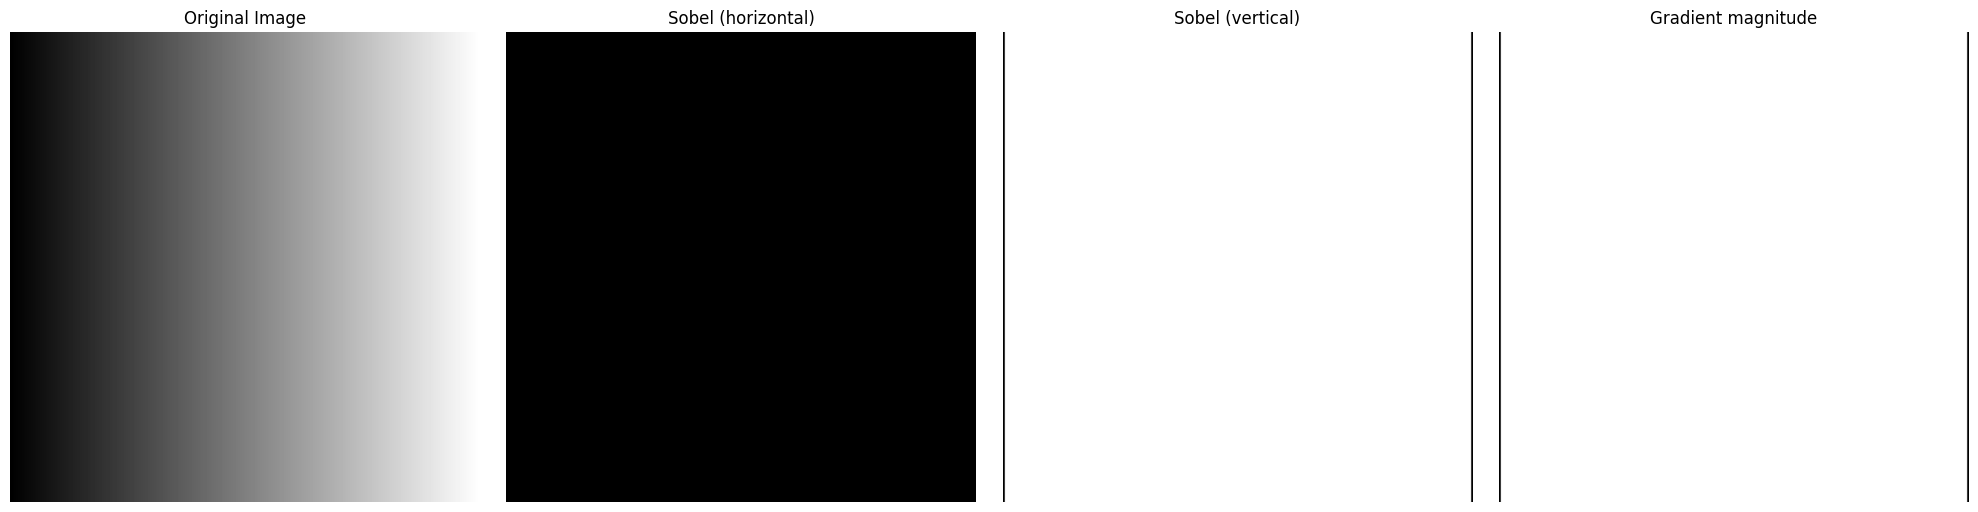

In [13]:
# Create a simple image with horizontal gradient
x = np.linspace(0, 1, 256)
y = np.ones_like(x)
image = np.outer(y, x)

# Compute gradient using Sobel operators
dx = ndimage.sobel(image, 0)  # horizontal derivative
dy = ndimage.sobel(image, 1)  # vertical derivative
mag = np.hypot(dx, dy)  # magnitude
mag *= 255.0 / np.max(mag)  # normalize (Q&D)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')

ax[1].imshow(dx, cmap=plt.cm.gray)
ax[1].set_title('Sobel (horizontal)')

ax[2].imshow(dy, cmap=plt.cm.gray)
ax[2].set_title('Sobel (vertical)')

ax[3].imshow(mag, cmap=plt.cm.gray)
ax[3].set_title('Gradient magnitude')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


### **Summary of Results**:

This demonstration illustrates how we can utilize Sobel operators to compute and visualize image gradients. Through these gradients, we can discern the structural and textural characteristics of the image, which are paramount for numerous applications in image processing and computer vision.

### **Vector Visualization of Image Gradients**:

To further appreciate how gradients represent changes in image intensity, we can visualize them as vectors. These vectors provide both a direction and magnitude of intensity change at each point in an image.

The upcoming vector diagram illustrates the horizontal gradient we crafted in our demonstration image:

- **Direction of Vectors**: Each vector depicts the gradient at a particular point in the space. In this scenario, all vectors point to the right, representing the clear horizontal gradient we've designed.
  
- **Magnitude of Vectors**: The length of each vector indicates the strength of the gradient. In this demonstration, all vectors have the same length because the gradient is consistent across the image.

- **Highlighted Vector**: Among the plotted vectors, we've spotlighted one as an example, emphasizing this representation method.

By visualizing gradients in this manner, we gain a clearer understanding of how they signify alterations in image intensity.

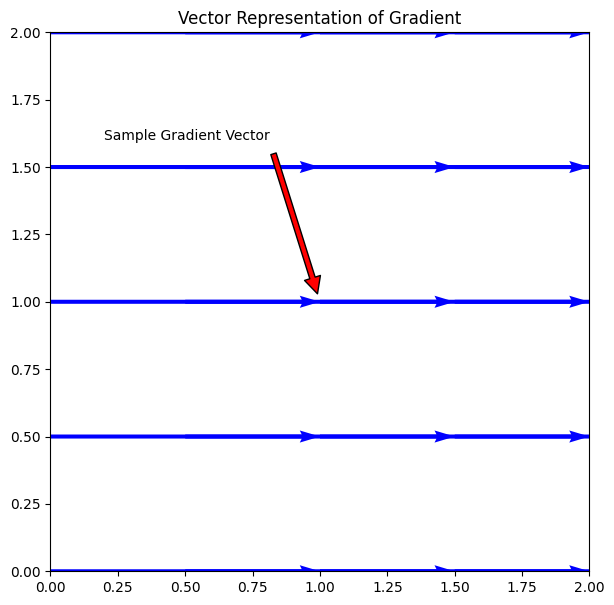

In [14]:
# Create a smaller grid for demonstration
x, y = np.mgrid[0:2:5j, 0:2:5j]

# Create a simple gradient (from left to right)
u = np.ones_like(x)
v = np.zeros_like(y)

fig, ax = plt.subplots(figsize=(7, 7))
ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='blue')
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal', 'box')
ax.set_title("Vector Representation of Gradient")

# Highlight a sample vector
ax.annotate('Sample Gradient Vector', xy=(1, 1), xytext=(0.2, 1.6),
             arrowprops=dict(facecolor='red', shrink=0.05),
             )

plt.show()


### **Diving Deeper into the Histogram of Oriented Gradients (HOG)**:

The Histogram of Oriented Gradients (HOG) offers a robust technique for feature extraction. Its effectiveness springs from its focus on capturing the structure and shape present in images, rather than merely concentrating on pixel intensity or color.

In the upcoming visual demonstration, we dissect an image of a boot. This image undergoes HOG processing, resulting in two distinct outputs:

1. **HOG Image**: This representation accentuates the dominant gradient directions in the image. Each white line or curve in the HOG image corresponds to the gradient's direction and intensity in the original image. In essence, this image captures the structural essence of the boot, emphasizing its contours and prominent features.

2. **HOG Features Histogram**: This bar plot offers a statistical summary of the oriented gradients in the image. Each bar represents the magnitude of gradients pointing in a specific direction. The taller the bar, the more dominant that particular gradient direction is in the image.

Together, these outputs provide a comprehensive understanding of the image's content, highlighting the boot's defining features and the distribution of its gradients.

The beauty of HOG lies in its resilience to variations in lighting and its keen focus on structural elements. These attributes make HOG particularly indispensable for tasks like image and object recognition where discerning the shape and structure of objects is paramount.

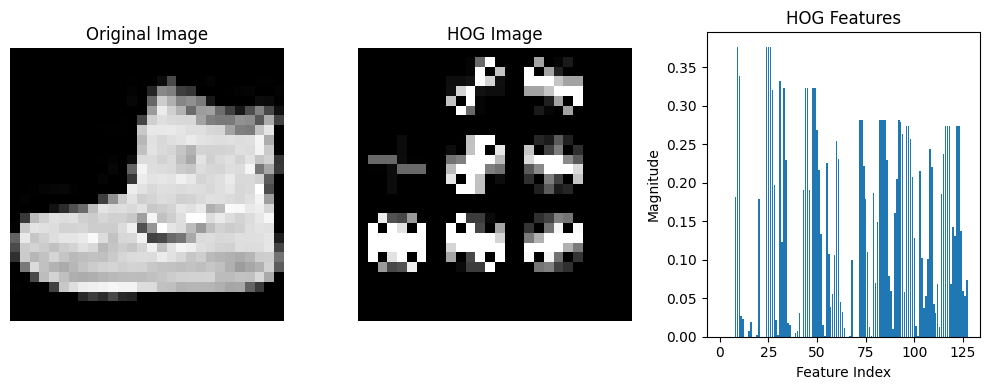

In [15]:
# Plotting the original image
plt.figure(figsize=(10, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# HOG Image
plt.subplot(1, 3, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title("HOG Image")
plt.axis('off')

# HOG Features (as a bar plot)
plt.subplot(1, 3, 3)
plt.bar(range(len(hog_features)), hog_features)
plt.title("HOG Features")
plt.xlabel("Feature Index")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


### **Feature Engineering with Histogram of Oriented Gradients (HOG)**:

The HOG methodology is a stellar tool for feature extraction, especially when distinguishing between different types of objects in images. By focusing on the structure and orientation of gradients in images, HOG provides a distinct representation that can be crucial in differentiating between categories.

In this exercise, we're interested in examining how the HOG features differ between various categories within the dataset. Specifically, we're delving into the comparison between pairs of categories: 'Shirt' vs. 'T-shirt/top' and 'Shirt' vs. 'Sandal'.

To ensure a fair comparison, we've sampled an equal number of images from each category, and the HOG features are extracted for each image in these samples. The next logical step in this analysis is to compute the average HOG features for each category. This average feature set will give us a consolidated representation for the category, smoothing out individual variances and emphasizing the consistent, defining characteristics.

In [16]:
num_samples = 500  # Number of samples to consider for each category

# Extract HOG features for a subset of images for each of the categories

def extract_hog_for_categories(category1_label, category2_label):
    category1_images = [train_images[i] for i, label in enumerate(train_labels) if label == category1_label][:num_samples]
    category2_images = [train_images[i] for i, label in enumerate(train_labels) if label == category2_label][:num_samples]

    category1_hog_features = []
    category2_hog_features = []

    for img in category1_images:
        features, _ = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        category1_hog_features.append(features)

    for img in category2_images:
        features, _ = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        category2_hog_features.append(features)

    # Convert to numpy arrays for easier calculations
    category1_hog_features = np.array(category1_hog_features)
    category2_hog_features = np.array(category2_hog_features)

    # Calculate average HOG features
    avg_category1_hog_features = category1_hog_features.mean(axis=0)
    avg_category2_hog_features = category2_hog_features.mean(axis=0)

    return avg_category1_hog_features, avg_category2_hog_features

# Extract average HOG features for the category pairs
avg_shirt_tshirt_features, avg_tshirt_top_features = extract_hog_for_categories(6, 0)
avg_shirt_sandal_features, avg_sandal_features = extract_hog_for_categories(6, 5)

avg_shirt_tshirt_features.shape, avg_tshirt_top_features.shape, avg_shirt_sandal_features.shape, avg_sandal_features.shape


((128,), (128,), (128,), (128,))

**Results**:
Our feature extraction resulted in HOG features of shape (128,) for each category. This uniformity in feature length is crucial, ensuring that we can meaningfully compare these features across categories. This consistency is one of the reasons why HOG is favored for tasks like this. With these features in hand, we can now proceed to visualize or classify them, further understanding the distinctions between our chosen categories.

### **Visual Comparison of Average HOG Features**:

To better understand how different categories differ in terms of their structure and texture, visualizing the HOG features is paramount. By plotting the average HOG features of each category, we can discern patterns and differences that might be indicative of the unique characteristics inherent to each category.

In the following visualizations, we will juxtapose the average HOG features of two pairs of categories: 'Shirt' vs. 'T-shirt/top' and 'Shirt' vs. 'Sandal'. These visual comparisons will shed light on the similarities and variances between these categories, providing insights into the kind of information captured by the HOG descriptors.

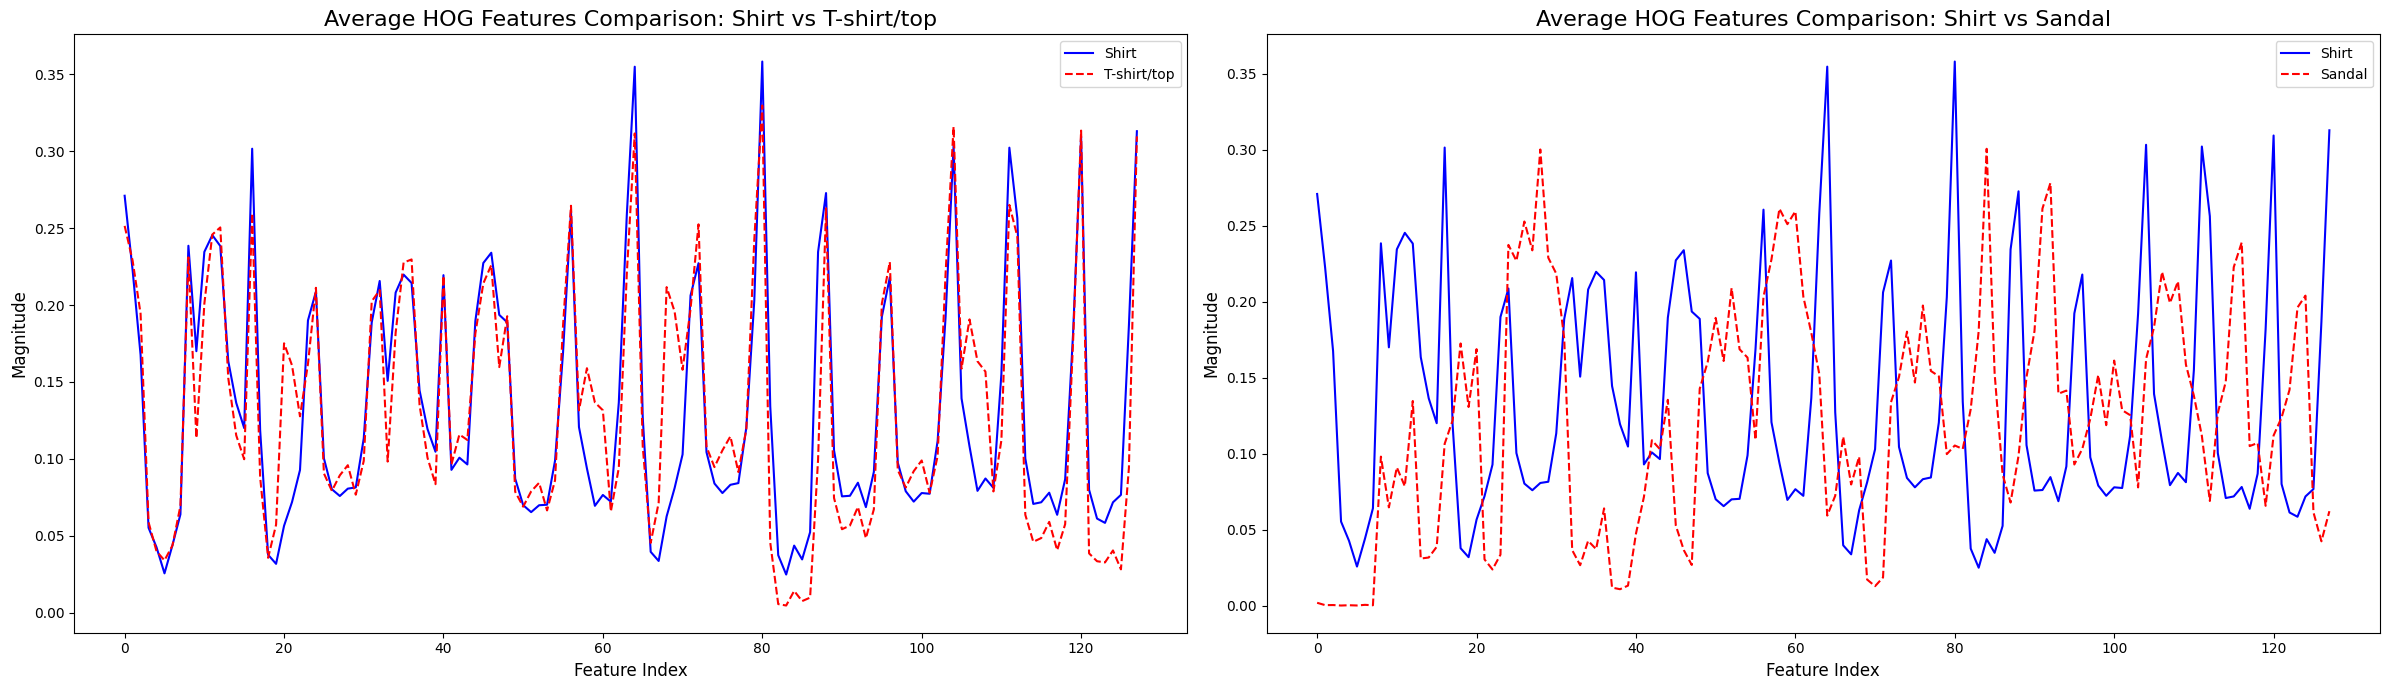

In [17]:
# Visualizing average HOG features for "Shirt" vs "T-shirt/top" and "Shirt" vs "Sandal"

def visualize_hog_comparison(features1, features2, title1, title2, ax):
    ax.plot(features1, label=title1, color='blue')
    ax.plot(features2, label=title2, color='red', linestyle='--')
    ax.set_xlabel("Feature Index", fontsize=12)
    ax.set_ylabel("Magnitude", fontsize=12)
    ax.set_title(f"Average HOG Features Comparison: {title1} vs {title2}", fontsize=16)
    ax.legend()

# Create a single figure and axes for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))

# Visualize the comparisons using the modified function
visualize_hog_comparison(avg_shirt_tshirt_features, avg_tshirt_top_features, "Shirt", "T-shirt/top", ax1)
visualize_hog_comparison(avg_shirt_sandal_features, avg_sandal_features, "Shirt", "Sandal", ax2)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


**Observations**:

From the above visualizations, several insights can be gleaned:

1. **Distinct Peaks and Troughs**: Specific indices in the HOG features showcase pronounced peaks or troughs, highlighting areas where the categories exhibit stark differences.
2. **Overlapping Patterns**: Some portions of the graphs overlap, indicating similarities between the categories in those feature indices.
3. **Divergence in Features**: The differences in the patterns between categories emphasize the capability of HOG features to capture unique textures and structures inherent to different categories.

These visual insights reinforce the potency of HOG features in distinguishing between different types of images based on their structural and textural patterns.

### **Visualizing average HOG images for "Shirt", "T-shirt/top", and "Sandal" categories**

The Histogram of Oriented Gradients (HOG) is a powerful feature descriptor that's especially adept at capturing the structure and form within an image. What we're about to visualize are the average HOG representations for images across different categories. Each "cell" in the visualization signifies a local region of the image where HOG features have been computed.

The visualizations can be interpreted as follows:

- **Gradient Orientations**: The lines within each cell indicate the dominant gradient orientation for that region. For instance, if a primary edge in a region is vertical, you would observe an upward-downward directed line.
  
- **Gradient Magnitudes**: The length of the lines within the cells represents the strength (or magnitude) of the gradients. Longer lines suggest a more significant change in pixel intensity within that region.
  
- **Local Information**: Given that HOG computations are local to each cell, it provides granular insights into the shape and structure of objects in the image.

With this in mind, let's delve into the visual representations of HOG for the "Shirt", "T-shirt/top", and "Sandal" categories and discern the nuances that differentiate them.

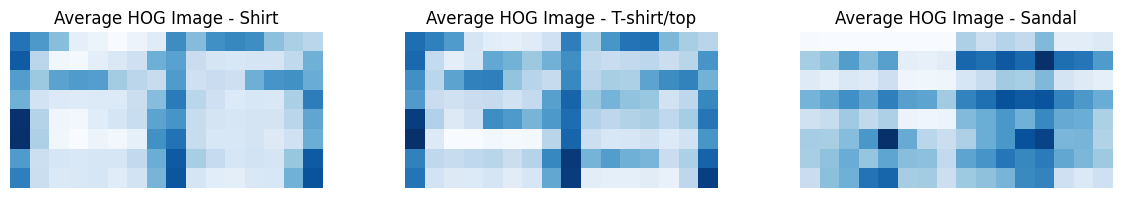

In [18]:
# Visualizing average HOG images for "Shirt", "T-shirt/top", and "Sandal" categories

plt.figure(figsize=(12, 2))

# Average HOG Image for T-shirt/top
plt.subplot(1, 3, 2)
plt.imshow(exposure.rescale_intensity(avg_tshirt_top_features.reshape(8, 16), in_range=(0, 10)), cmap='Blues')
plt.title("Average HOG Image - T-shirt/top")
plt.axis('off')

# Average HOG Image for Shirt
plt.subplot(1, 3, 1)
plt.imshow(exposure.rescale_intensity(avg_shirt_tshirt_features.reshape(8, 16), in_range=(0, 10)), cmap='Blues')
plt.title("Average HOG Image - Shirt")
plt.axis('off')

# Average HOG Image for Sandal
plt.subplot(1, 3, 3)
plt.imshow(exposure.rescale_intensity(avg_sandal_features.reshape(8, 16), in_range=(0, 10)), cmap='Blues')
plt.title("Average HOG Image - Sandal")
plt.axis('off')

plt.tight_layout()
plt.show()


### **Observing HOG Visualizations**

From the visualizations, some observations become apparent:

- **Feature Recognition**: The HOG visualizations offer a glimpse into the key structural features of each category. For instance, if two categories exhibit similar HOG visualizations, it might suggest that they share similar structural attributes or textures.

- **Category Distinctions**: If the HOG visualizations for two categories differ substantially, it indicates that these categories possess distinct structures and textures. This insight can be instrumental when attempting to distinguish or classify such categories.

- **Model Enhancement**: Leveraging HOG features as input data for machine learning models can be beneficial. If a model struggles with raw pixel data, the structured, edge-focused information from HOG might offer a more discernible pattern that the model can latch onto. This structural insight, especially for image classification tasks, can significantly boost model accuracy and generalization capabilities.

### **Diving into HOG Feature Statistics**:

As we seek to comprehend the essence of images, delving into the numerical attributes of their HOG features can be enlightening. The Histogram of Oriented Gradients (HOG) offers a nuanced view of image contours and structures. By aggregating the average HOG features for various product categories such as "Shirt", "T-shirt/top", and "Sandal" and extracting descriptive statistics like mean, standard deviation, minimum, and maximum values, we can gain a quantitative understanding of the image characteristics and their variability.

In [19]:
# Calculating statistical data for the HOG features
data = {
    "Category": ["Shirt", "T-shirt/top", "Sandal"],
    "Mean": [avg_shirt_tshirt_features.mean(), avg_tshirt_top_features.mean(), avg_sandal_features.mean()],
    "Standard Deviation": [avg_shirt_tshirt_features.std(), avg_tshirt_top_features.std(), avg_sandal_features.std()],
    "Min Value": [avg_shirt_tshirt_features.min(), avg_tshirt_top_features.min(), avg_sandal_features.min()],
    "Max Value": [avg_shirt_tshirt_features.max(), avg_tshirt_top_features.max(), avg_sandal_features.max()]
}

# Creating a DataFrame
hog_features_stats = pd.DataFrame(data)

hog_features_stats


,Category,Mean,Standard Deviation,Min Value,Max Value
0,Shirt,0.133125,0.078980,0.024912,0.358195
1,T-shirt/top,0.131430,0.079224,0.004776,0.329643
2,Sandal,0.122318,0.075625,0.000019,0.300740


### **Observations**:

Upon examination of the tabulated statistics:

1. **Mean HOG Features**: The mean magnitudes across the categories are relatively close, with the "Shirt" having the highest average magnitude followed closely by "T-shirt/top". The "Sandal" category has a slightly lower mean, suggesting its features might be less pronounced than the other two.

2. **Variability in HOG Features**: The standard deviation values hint at a similar level of variability or spread in the HOG features across all three categories.

3. **Range of HOG Features**: The "Shirt" category exhibits the highest maximum magnitude, suggesting that some of its features are particularly dominant. Meanwhile, the "Sandal" has the lowest minimum value, almost reaching zero, indicating some features with very subtle gradients.

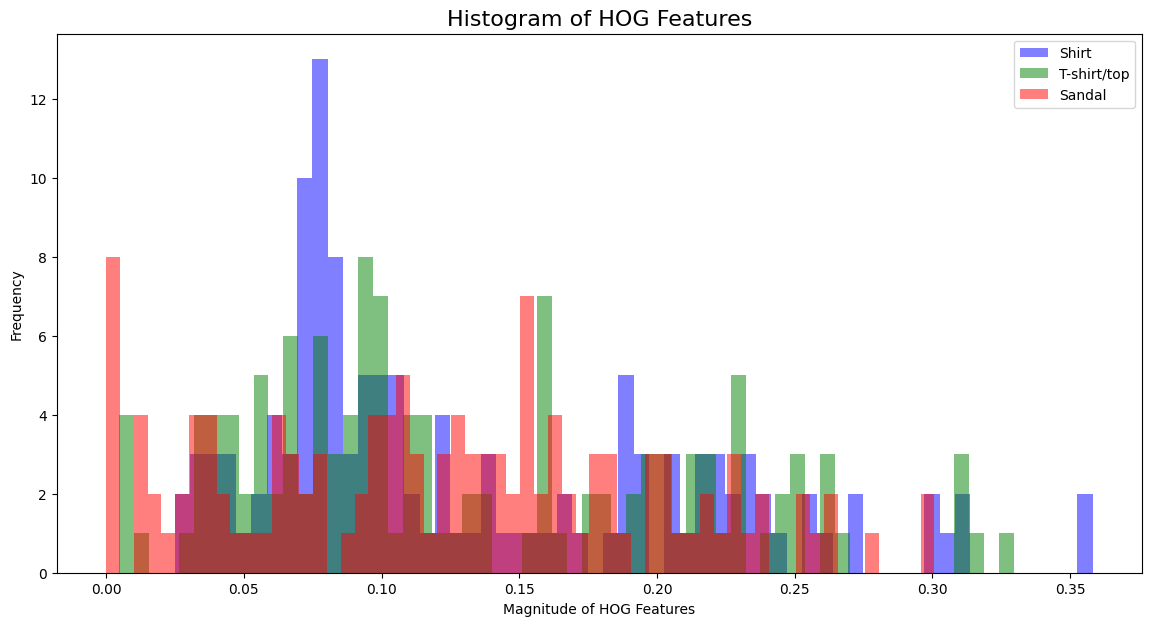

In [20]:
# Plotting the histograms of HOG features for the three categories

plt.figure(figsize=(14, 7))

# Shirt
plt.hist(avg_shirt_tshirt_features, bins=60, alpha=0.5, label="Shirt", color='blue')
# T-shirt/top
plt.hist(avg_tshirt_top_features, bins=60, alpha=0.5, label="T-shirt/top", color='green')
# Sandal
plt.hist(avg_sandal_features, bins=60, alpha=0.5, label="Sandal", color='red')

plt.title("Histogram of HOG Features", fontsize=16)
plt.xlabel("Magnitude of HOG Features")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### **Observations from the histograms**:

- The distributions of the HOG features for the three categories overlap considerably, highlighting their shared structural elements. However, each category has its distinct peaks and troughs, signifying unique features.
  
- The "Shirt" and "T-shirt/top" distributions seem more congruent than the "Sandal", emphasizing the greater structural similarity between shirts and t-shirts compared to sandals.

In essence, while there are shared structural elements across these categories, each has its unique HOG feature patterns that can be leveraged for differentiation and categorization tasks.

### Insights from HOG:

- **Emphasis on Shape**: The HOG descriptor captures information primarily centered around the geometric shapes and structures in an image, sidelining color attributes. This makes it particularly suitable for analyzing datasets like Fashion MNIST, where the shape and texture of objects are paramount.
  
- **Stability Across Varying Conditions**: HOG demonstrates resilience to changes in illumination and contrast. This robustness renders it appropriate for real-world applications where imaging conditions can fluctuate.

- **Versatility in Application**: HOG can be harnessed for a multitude of image processing tasks ranging from classification to object recognition and more. In your endeavor, HOG can serve as a feature extraction tool, which can subsequently be employed for analyzing or modeling the Fashion MNIST data.

- **Differential Power**: HOG's detailed representation of gradient information allows it to differentiate between similar-looking objects or categories effectively. As seen in the comparisons, even closely related categories like "Shirt" and "T-shirt/top" have discernible differences in their HOG representations.

- **Integration with Machine Learning**: HOG features can be seamlessly integrated with machine learning models, providing them with structured and meaningful input data. Such a combination often leads to improved model performance, especially in tasks like image classification.

---

### **Visualizing Predicted Anomalies and Normals with the Best Model**

To better understand the efficacy of our anomaly detection model, it's essential to visualize its predictions. The subsequent code utilizes the best parameters derived from previous steps to train an Isolation Forest model on the entire dataset. Once trained, the model will predict which images are anomalous and which are normal. We will then visualize a subset of both these categories. This will give us a tangible sense of the model's performance and help us ascertain if it's correctly identifying anomalous images or misclassifying normal ones.

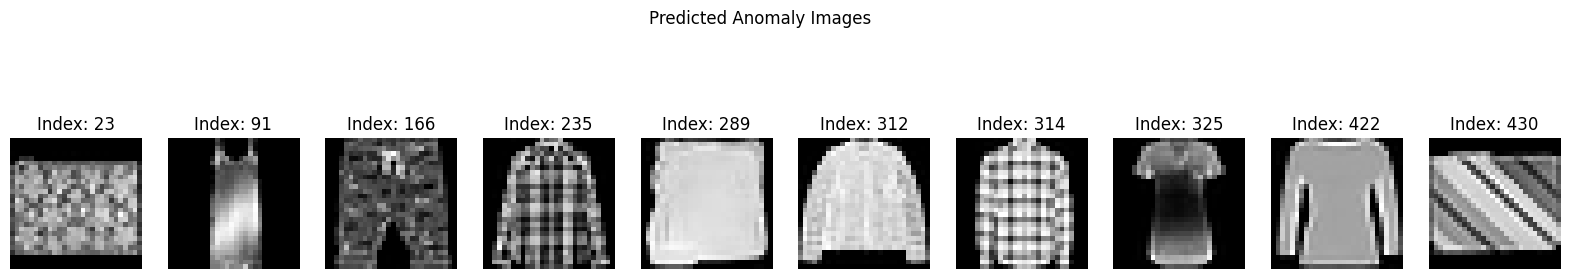

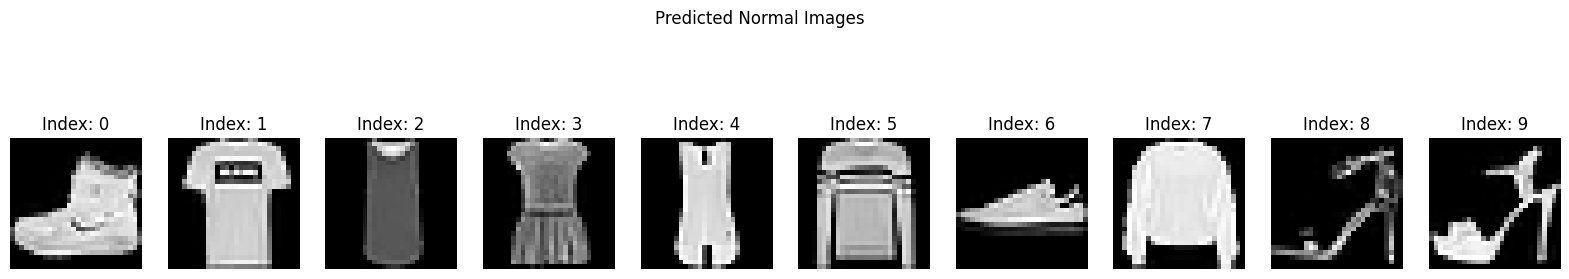

In [21]:
# Create a model with the best parameters
best_model = IsolationForest(random_state=42, 
                             n_estimators=best_params['n_estimators'], 
                             max_samples=best_params['max_samples'], 
                             contamination=best_params['contamination'])

# Model is trained on the whole dataset
best_model.fit(lbp_features)

# Predict labels with the model
predicted_labels = np.where(best_model.predict(lbp_features) == -1, 1, 0)

# Find the indices of the anomaly and normal images
anomaly_indices = np.where(predicted_labels == 1)[0]
normal_indices = np.where(predicted_labels == 0)[0]

# Visualize the anomaly and normal images
def plot_images(indices, title, images=train_images, n=10):
    """Visualize images with their indices."""
    plt.figure(figsize=(20, 4))
    for i, index in enumerate(indices[:n]):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[index], cmap="gray")
        plt.title(f"Index: {index}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Visualize the anomaly and normal images
plot_images(anomaly_indices, "Predicted Anomaly Images")
plot_images(normal_indices, "Predicted Normal Images")


### **Observations:**

The visualizations offer a snapshot of the images classified as "anomalies" and those recognized as "normal" by our model. By examining these images, we can:

Validate Correct Predictions: Ensure that the images marked as anomalies do indeed deviate from the expected norm.
Identify Potential Misclassifications: Spot any normal images that might have been wrongly classified as anomalies or vice versa.
Refine the Model: If misclassifications are observed, it may be indicative of the need for model refinement or adjustments in the feature extraction process.

### **Class-wise Visualization of Predicted Anomalies and Normals**

The upcoming code segment focuses on a deeper, class-wise exploration of the Fashion MNIST dataset using our optimal Isolation Forest model. Instead of analyzing anomalies holistically across the dataset, we're zeroing in on each class to get a more nuanced understanding of the anomalies and normals specific to each category. The intent is to showcase a fixed number of images from each class, depicting both predicted anomalies and normals, enabling a granular inspection of the model's performance on a per-class basis.

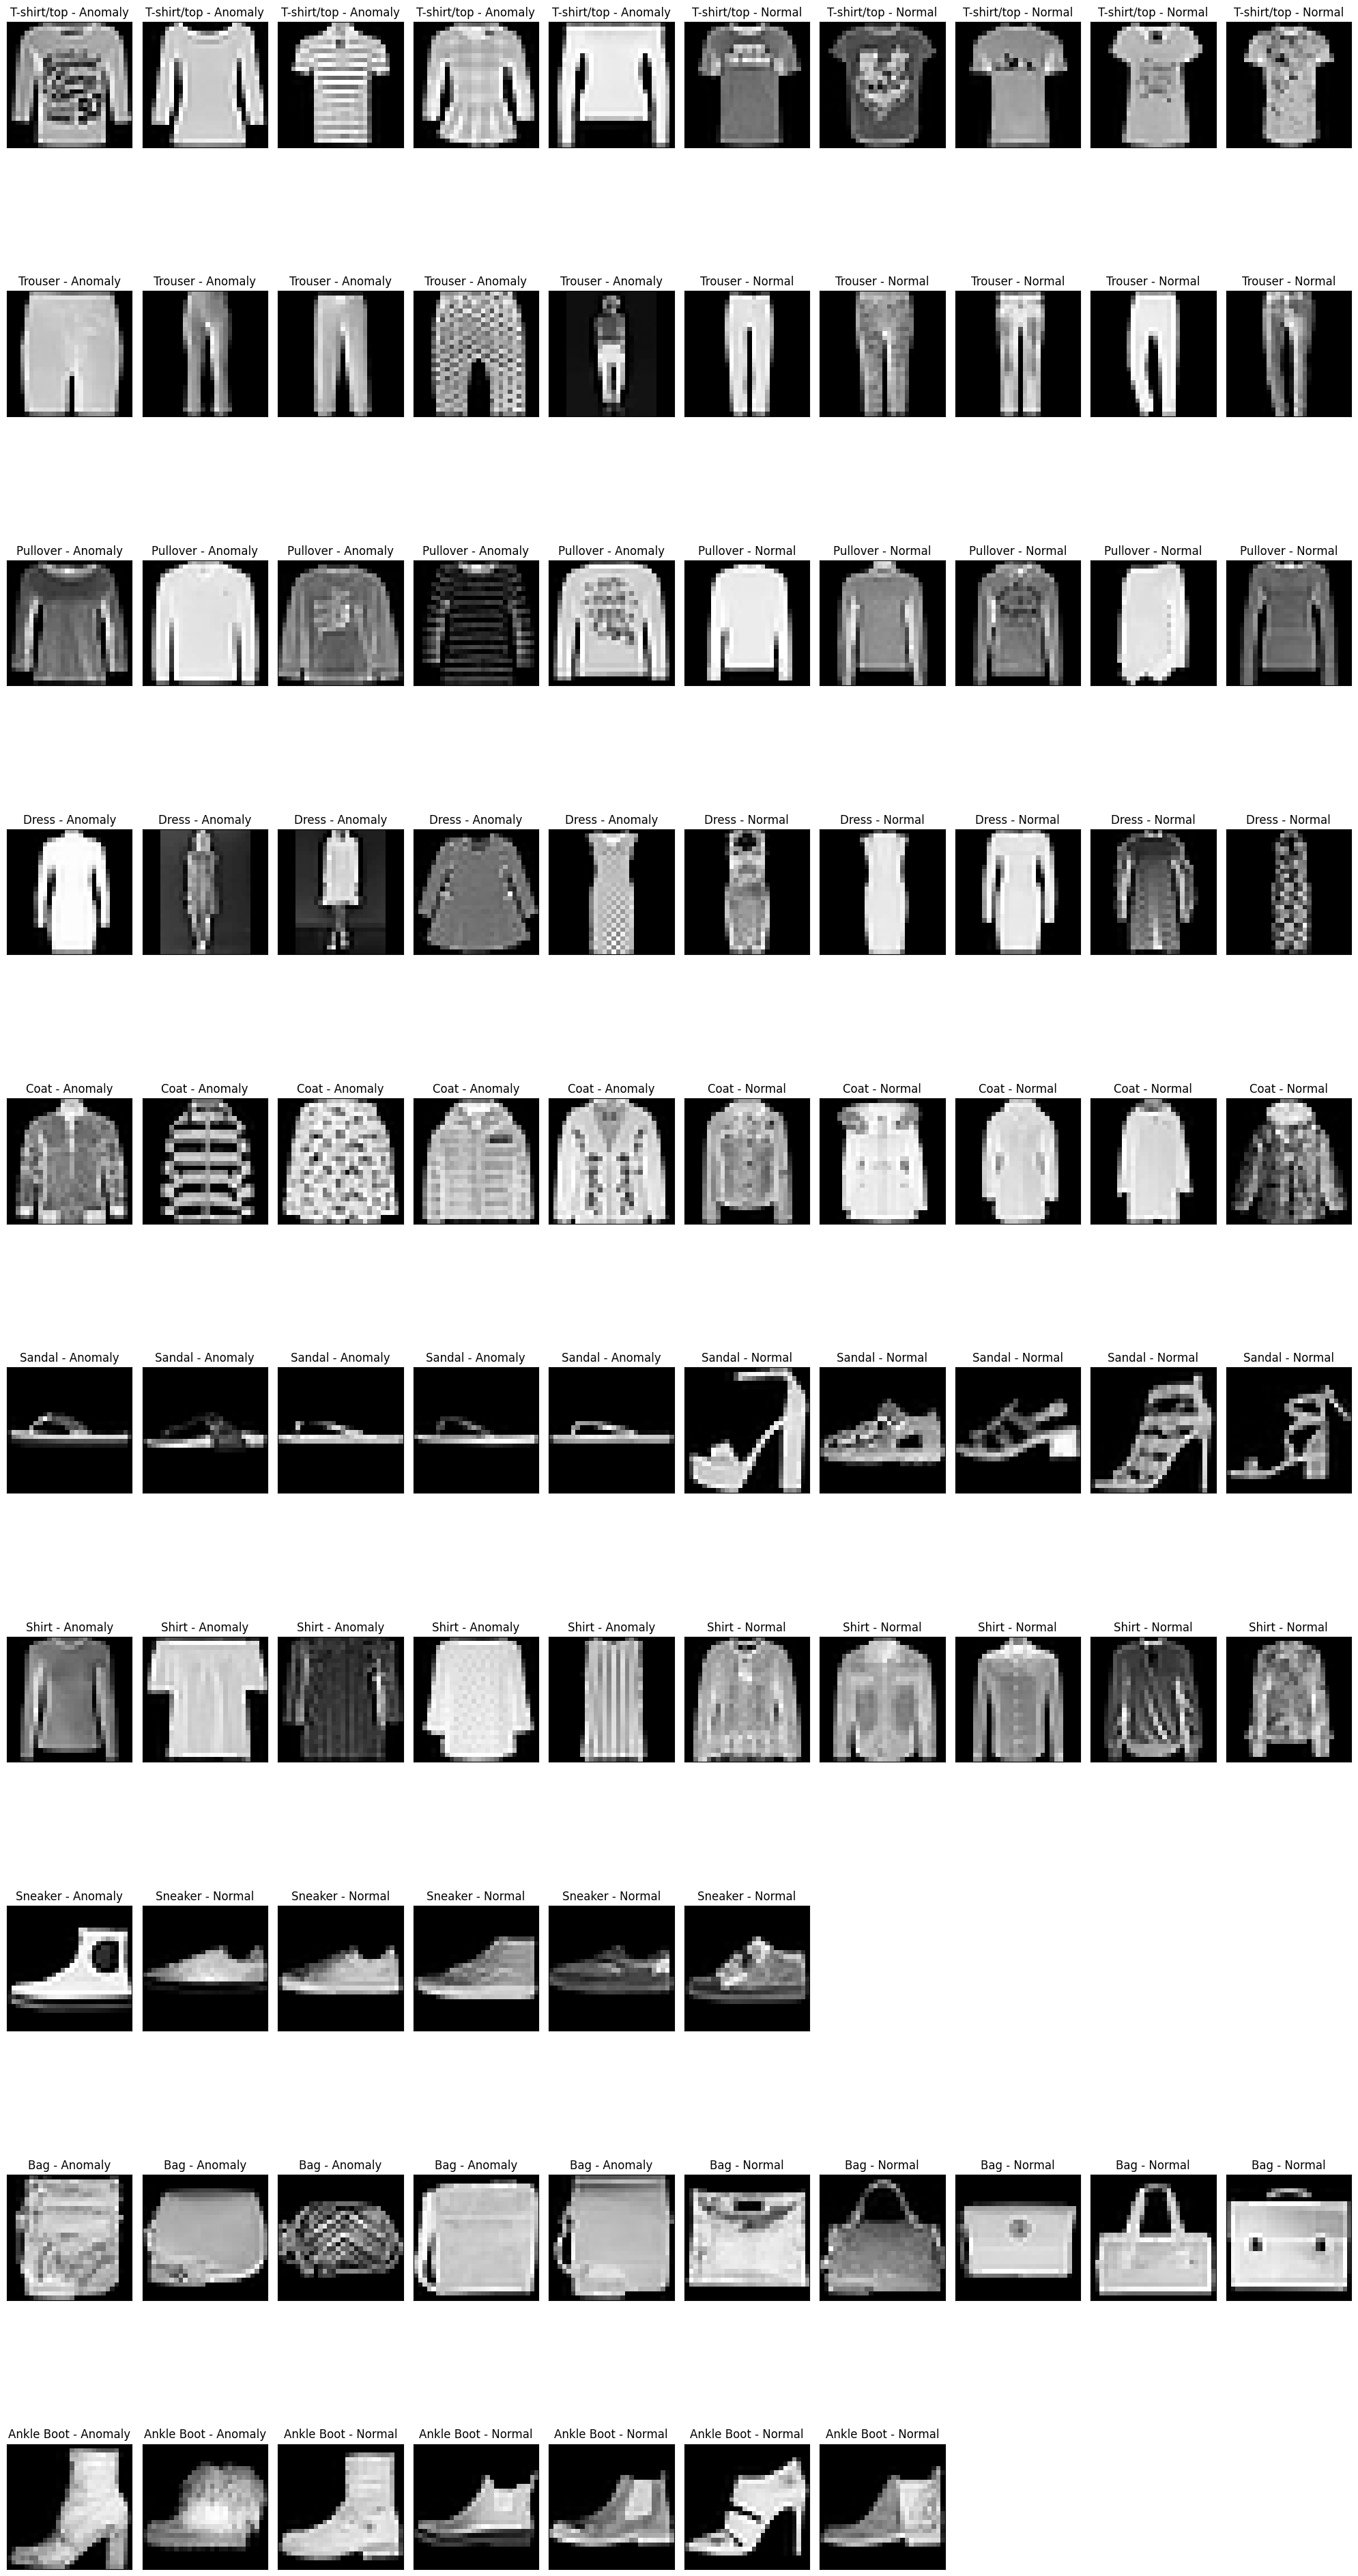

In [22]:
# Number of images you want to show for each class
num_images_per_class = 5


label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Predicting the labels with the model
predicted_labels = np.where(best_model.predict(lbp_features) == -1, 1, 0)

plt.figure(figsize=(20, 4 * len(label_names)))

for j, label_name in enumerate(label_names):
    label_index = label_names.index(label_name)
    
    # Find the indices of the anomaly and normal images for the current class
    anomaly_indices = np.where((predicted_labels == 1) & (train_labels[:len(predicted_labels)] == label_index))[0].tolist()
    normal_indices = np.where((predicted_labels == 0) & (train_labels[:len(predicted_labels)] == label_index))[0].tolist()
    
    # Choose equal number of random indices from both lists for the current class
    selected_anomaly_indices = random.sample(anomaly_indices, min(num_images_per_class, len(anomaly_indices)))
    selected_normal_indices = random.sample(normal_indices, min(num_images_per_class, len(normal_indices)))
    
    # Merge selected indices
    selected_indices = selected_anomaly_indices + selected_normal_indices
    
    # Visualize the images for the current class
    for i, index in enumerate(selected_indices):
        ax = plt.subplot(len(label_names), num_images_per_class * 2, j * num_images_per_class * 2 + i + 1)
        plt.imshow(train_images[index], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        title = f"{label_name} - "
        title += "Anomaly" if index in selected_anomaly_indices else "Normal"
        ax.set_title(title)

plt.tight_layout()
plt.show()


### **Insights:**
From the displayed visuals, we can gather insights on a class-specific level:

1. **Fine-grained Evaluation**: By looking at anomalies and normals for each class separately, we get a clearer picture of where the model excels and where it might be struggling.
2. **Nature of Anomalies**: This display offers an understanding of what constitutes an "anomaly" within each class. For instance, slight deviations in design or unusual patterns might lead an image to be flagged as anomalous.
3. **Potential Overlaps**: If some "normal" images for one class resemble "anomalies" in another, it might indicate overlapping features between these classes, suggesting that the model finds them challenging to discern.
4. **Guidance for Refinement**: Observing misclassifications or unexpected anomalies can be a guiding light for further refining our feature extraction methods or re-tuning the model.

### **Class-wise Breakdown of Normal vs. Anomaly Counts**
---
The subsequent section provides a numerical breakdown of how many images in each category of the Fashion MNIST dataset were classified as normal or anomalous by our Isolation Forest model. This detailed, class-wise quantification allows us to assess the distribution of detected anomalies across different categories. By juxtaposing the counts of normal images against the anomalies for each class, we aim to discern patterns or disparities in the model's anomaly detection behavior across the diverse range of clothing items.

In [23]:
# Initialize lists for storing the counts of normal and anomaly images
normal_counts = []
anomaly_counts = []

# Iterate over each class and count the normal and anomaly images
for label_name in label_names:
    label_index = label_names.index(label_name)
    normal_count = np.sum((predicted_labels == 0) & (train_labels[:len(predicted_labels)] == label_index))
    anomaly_count = np.sum((predicted_labels == 1) & (train_labels[:len(predicted_labels)] == label_index))
    normal_counts.append(normal_count)
    anomaly_counts.append(anomaly_count)

# Create a DataFrame with the counts
df = pd.DataFrame({
    'Label': label_names,
    'Normal': normal_counts,
    'Anomaly': anomaly_counts
})

df


,Label,Normal,Anomaly
0,T-shirt/top,5906,94
1,Trouser,5944,56
2,Pullover,5839,161
3,Dress,5952,48
4,Coat,5969,31
5,Sandal,5885,115
6,Shirt,5769,231
7,Sneaker,5999,1
8,Bag,5748,252
9,Ankle Boot,5998,2


### **Observations and Implications:**
Upon reviewing the output table and the corresponding bar chart:

1. **Differential Anomaly Detections**: The model doesn't uniformly detect anomalies across categories. Some classes, like "Shirt" and "Bag", seem to have higher anomaly counts, whereas others, such as "Sneaker" and "Ankle Boot", have very few detected anomalies.
   
2. **Potential Challenges**: The disparity in anomaly detection might indicate that certain classes inherently possess more variability or ambiguous patterns, leading to higher anomaly counts. Alternatively, it might suggest that our feature extraction or model parameters need tuning for those specific classes.

3. **Model's Robustness**: The very low anomaly counts in categories like "Sneaker" and "Ankle Boot" hint at the model's confidence in recognizing the typical structure of these items.

### **Visualizing Class-wise Anomaly Distribution**

The subsequent section visually illustrates the distribution of normal and anomalous images across various categories in the Fashion MNIST dataset. Through the comparative bar chart, we can vividly perceive the extent of anomalies detected by our model for each category. By juxtaposing these visual patterns, we hope to gain a deeper understanding of the model's behavior across diverse clothing items.

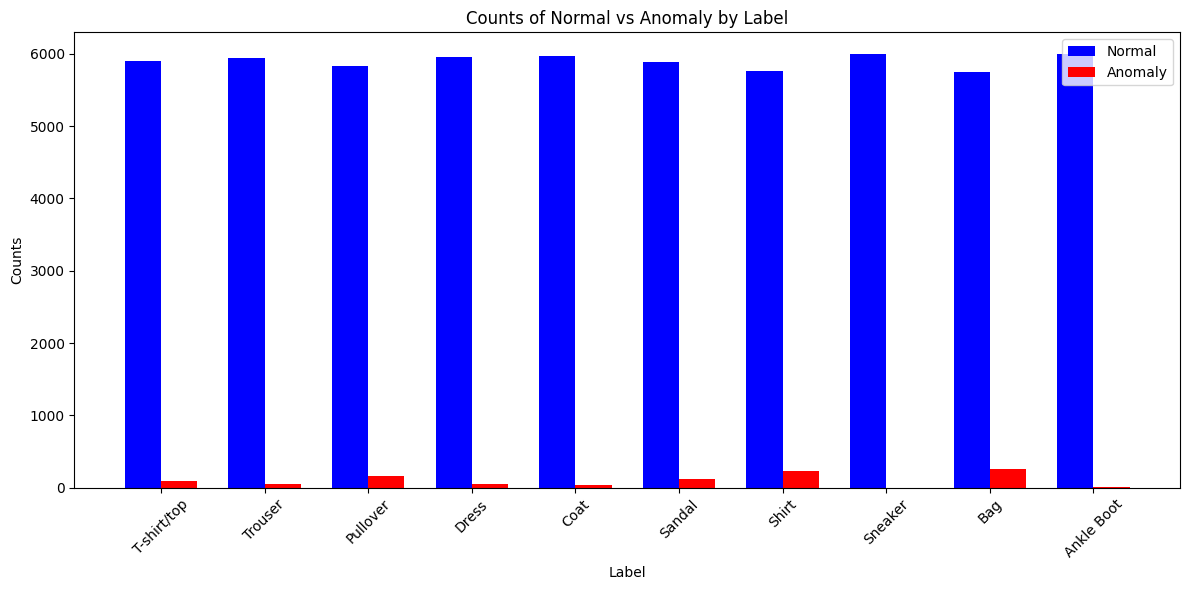

In [24]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot for 'Normal' counts
bar_width = 0.35
index = np.arange(len(label_names))
bar1 = ax.bar(index, df['Normal'], bar_width, label='Normal', color='b')

# Create a bar plot for 'Anomaly' counts right next to the 'Normal' bars
bar2 = ax.bar(index + bar_width, df['Anomaly'], bar_width, label='Anomaly', color='r')

# Label the chart
ax.set_xlabel('Label')
ax.set_ylabel('Counts')
ax.set_title('Counts of Normal vs Anomaly by Label')
ax.set_xticks(index + bar_width / 2)  # Position the label in the center of the two bars
ax.set_xticklabels(label_names, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


### **Insights from the Bar Chart:**

1. **Variability in Anomalies**: The chart distinctly showcases that anomalies aren't uniformly distributed. Categories like "Shirt" and "Bag" demonstrate higher anomaly counts relative to others.
   
2. **Consistent Recognition**: The almost negligible anomalies in "Sneaker" and "Ankle Boot" emphasize the model's adeptness in recognizing typical patterns within these categories.

3. **Comparative Insights**: The side-by-side bars provide a comparative perspective. For instance, while "Pullover" and "Sandal" have a similar count of normal images, their anomaly counts differ, indicating varied challenges in their respective pattern recognitions.

4. **Scope for Model Refinement**: High anomalies in certain categories might necessitate a review of the feature extraction methods or model parameters tailored to those specific classes.

---

## Conclusion

Through our exploration of the Fashion MNIST dataset using various techniques, we delved deep into the intricacies of image structures and textures. The Histogram of Oriented Gradients (HOG) emerged as a compelling feature descriptor that captured the essence of images by focusing on their structural aspects rather than color or intensity. By visualizing and comparing HOG representations across categories, we could discern subtle nuances and patterns characterizing different fashion items.

In our anomaly detection journey, the Isolation Forest algorithm played a pivotal role in identifying anomalies within various fashion categories. The subsequent visualizations of these anomalies, especially when contrasted against typical samples, offered profound insights into the nature and characteristics of these outliers.

The multidimensional visualization techniques like PCA provided a holistic view of the data distribution. It became evident that anomalies often reside on the peripheries of typical data clusters, indicating their pronounced deviations from the norm.

The potential applications of our findings are vast. In real-world scenarios, such as quality control in manufacturing, the early detection of anomalous products can lead to substantial cost savings and efficiency improvements. The methodologies we've explored aren't confined to fashion items; they possess the versatility to be adapted across various domains, underscoring the universal applicability of anomaly detection and feature extraction techniques like HOG.

---

[Back to Main](../Project.ipynb)